# Check Impact of ```n_splits``` on Classification Uncertainties

<hr/>

## Prerequisites

#### Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import pandas as pd

from ensemble_uncertainties.model_library import models
from ensemble_uncertainties.evaluators.evaluator_support import format_time_elapsed
from ensemble_uncertainties.evaluators.regression_evaluator import RegressionEvaluator
from ensemble_uncertainties.evaluators.classification_evaluator import ClassificationEvaluator

from ensemble_uncertainties.utils.ad_assessment import rmses_frac, cumulative_accuracy
from sklearn.metrics import roc_curve


#### Settings

In [2]:
mpl.rcParams['figure.dpi'] = 200

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import xgboost as xgb

xgb.set_config(verbosity=0)

1 Physical GPUs, 1 Logical GPUs


2022-02-28 15:48:14.196655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 15:48:14.215476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 15:48:14.215650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 15:48:14.216314: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

#### Constants

In [3]:
REPETITIONS = 10
TASK = 'classification'
TRYOUT_SPLITS = [2, 3, 5]
PLOT_FOLDER = './classification_plots/'

#### Functions

In [4]:
def load_data_set(name, descriptor):
    """Loads X and y as dataframes from data folder."""
    folder = f'~/PowerFolders/ensemble_ad/data/featurized/{TASK}/{name}/'
    X_file = f'{folder}{name}_{descriptor}.csv'
    y_file = f'{folder}{name}_y.csv'
    X = pd.read_csv(X_file, sep=';').set_index('id')
    y = pd.read_csv(y_file, sep=';').set_index('id')
    return X, y

def get_measure_accs(evaluator, start_frac):
    """Extracts confidence curve values from an Evaluator."""
    y = evaluator.y['y']
    preds = evaluator.test_ensemble_preds['correct']
    probs = evaluator.test_ensemble_preds['probA']
    accuracies = cumulative_accuracy(y, preds, probs, start_frac=start_frac)
    return accuracies

def get_fpr_tpr(evaluator):
    """Extracts confidence curve values from an Evaluator."""
    y = evaluator.y['y']
    probs = evaluator.test_ensemble_preds['probA']
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr


def plot_both(evaluators, title, ax1, ax2, start_frac=.05):
    """Plots ROC and cumulated accuracy curves for several evaluators."""
    n_splitss = list()
    times = list()
    formatted_times = list()
    # Plot uncertainty performances
    ax1.grid(zorder=1000)
    for evaluator in evaluators:
        n_splits = evaluator.n_splits
        n_splitss.append(n_splits)
        times.append(
            evaluator.overall_run_time.total_seconds()
        )
        formatted_times.append(
            format_time_elapsed(evaluator.overall_run_time).replace('.', '\n')
        )
        fpr, tpr = get_fpr_tpr(evaluator)
        ax1.plot(fpr, tpr, zorder=100, label=f'n_splits = {n_splits}')
        
        accs = get_measure_accs(evaluator, start_frac)
        x_space = np.linspace(100 * start_frac, 100.0, len(accs))
        ax2.plot(x_space, accs, zorder=100, 
            label=f'n_splits = {n_splits}')
    
    ax2.set_title(title)
    ax2.set_xlabel('Percentile')
    ax2.set_ylabel('$ACC$')
    ax2.legend()
        
    
    ax1.plot([0.0, 1.0], [0.0, 1.0], zorder=100, color='k', label='Random', linestyle='dashed')    
    ax1.set_title(title)
    ax1.set_xlabel('False positive rate')
    ax1.set_ylabel('True positive rate')
    ax1.legend()
   
    colors = dict(zip([f'n_splits = {n}' for n in n_splitss], [f'C{i}' for i in range(len(n_splitss))]))        
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    ax2.legend(handles, labels)
    
def compare_n_folds(name, descriptor, model_name, ax1, ax2, tryout_splits=TRYOUT_SPLITS, repetitions=REPETITIONS):
    """Evaluates the uncertainty estimation for one dataset, one model,
    and one descriptor, but for several splits, and plots the results.
    """
    X, y = load_data_set(name, descriptor)
    model = models['classification'][model_name]
    evaluators = list()
    for i, n_splits in enumerate(tryout_splits):
        print(f'Repetition [{i+1}/{len(tryout_splits)}]')
        evaluator = ClassificationEvaluator(
                        model=model,
                        repetitions=repetitions,
                        n_splits=n_splits,
                        verbose=False
        )
        evaluator.perform(X, y)
        evaluators.append(evaluator)
    plot_both(evaluators, f'{name}, {descriptor}, {model_name}, {repetitions} repetitions', ax1, ax2)

    
def evaluation_automatization(name, descriptor, methods, tryout_splits=TRYOUT_SPLITS,
                              repetitions=REPETITIONS, plots_folder=PLOT_FOLDER):
    """Evaluates the uncertainty estimation for one dataset featurized by
    one descriptor, several models, several splits, and plots the results.
    """
    n_methods = len(methods)
    fig, pre_axes = plt.subplots(2, n_methods, figsize=(5*n_methods, 10))
    # Transpose axes
    axes = zip(*pre_axes)
    for method, ax in zip(methods, axes):
        uax, tax = ax
        compare_n_folds(name, descriptor, method, uax, tax, tryout_splits=tryout_splits, repetitions=repetitions)
    if plots_folder:
        image_path = f'{plots_folder}{name}_{descriptor}_{"_".join(methods)}.png'
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.01)
    plt.show()    

<hr/>

## Evaluate

#### Test a small run:

In [5]:
# evaluation_automatization('bbbp', 'cddd', ['rf', 'svm_rbf', 'xgb', 'shallow', 'deep'], repetitions=3)

#### Testing repetitions bbbp:

Repetition [1/3]


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]


Repetition [2/3]


100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 3/3 [00:07<00:00,  2.55s/it]


Repetition [1/3]


100%|█████████████████████████████████████████████| 3/3 [00:08<00:00,  2.94s/it]


Repetition [2/3]


100%|█████████████████████████████████████████████| 3/3 [00:18<00:00,  6.26s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 3/3 [00:39<00:00, 13.05s/it]


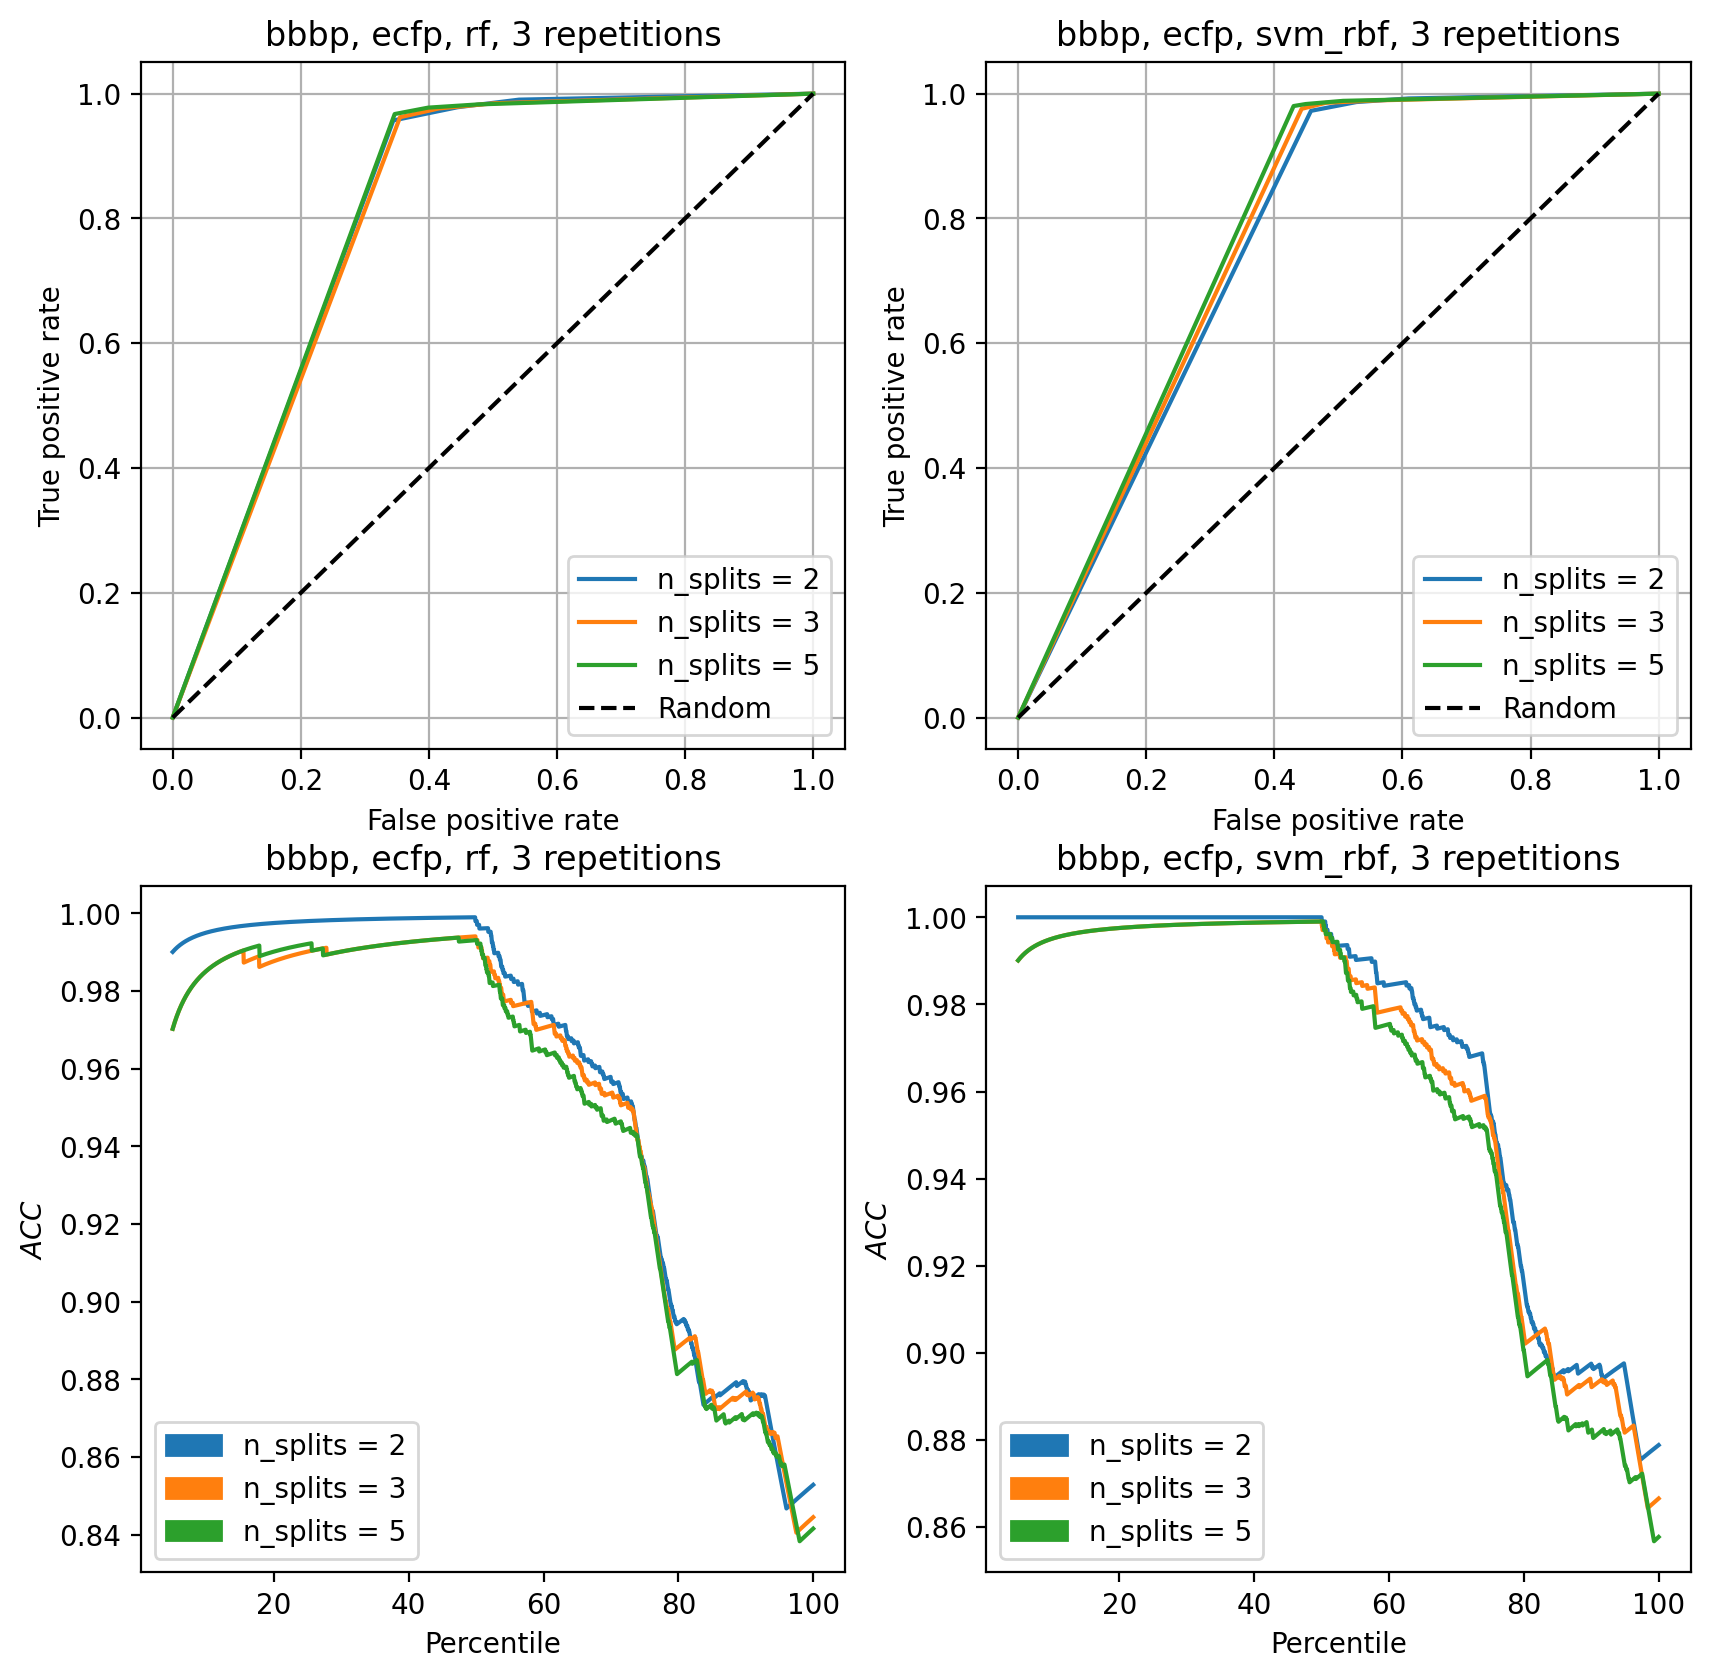

In [6]:
evaluation_automatization('bbbp', 'ecfp', ['rf', 'svm_rbf'], repetitions=3)

Repetition [1/3]


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]


Repetition [2/3]


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


Repetition [1/3]


100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.14s/it]


Repetition [2/3]


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.30s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 5/5 [01:02<00:00, 12.56s/it]


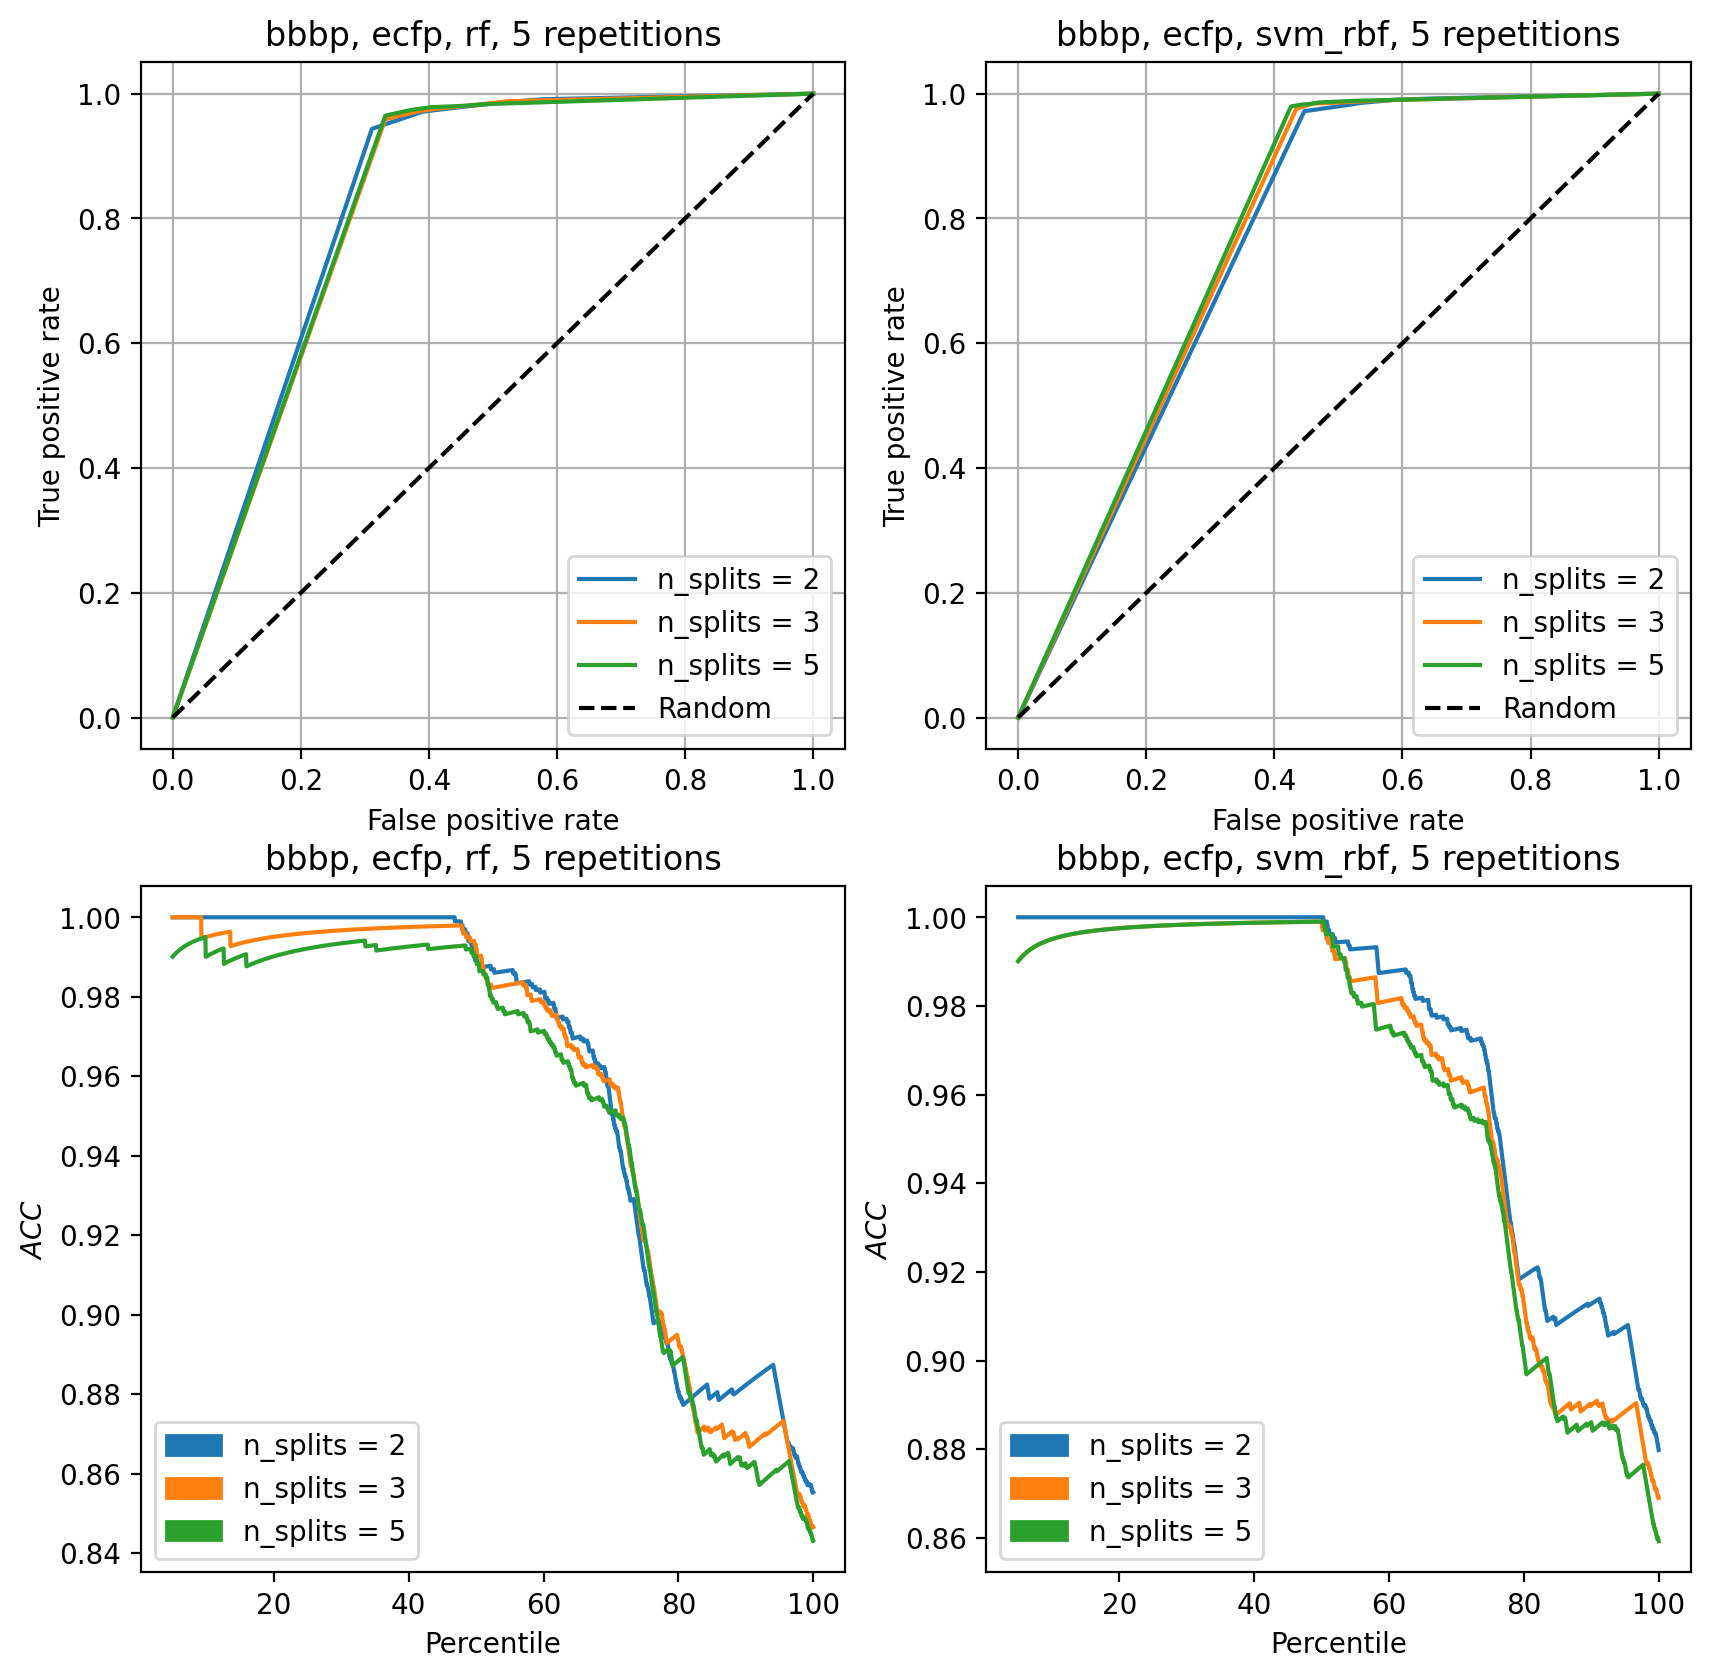

In [7]:
evaluation_automatization('bbbp', 'ecfp', ['rf', 'svm_rbf'], repetitions=5)

Repetition [1/3]


100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.30s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.18s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 10/10 [01:00<00:00,  6.07s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 10/10 [02:02<00:00, 12.23s/it]


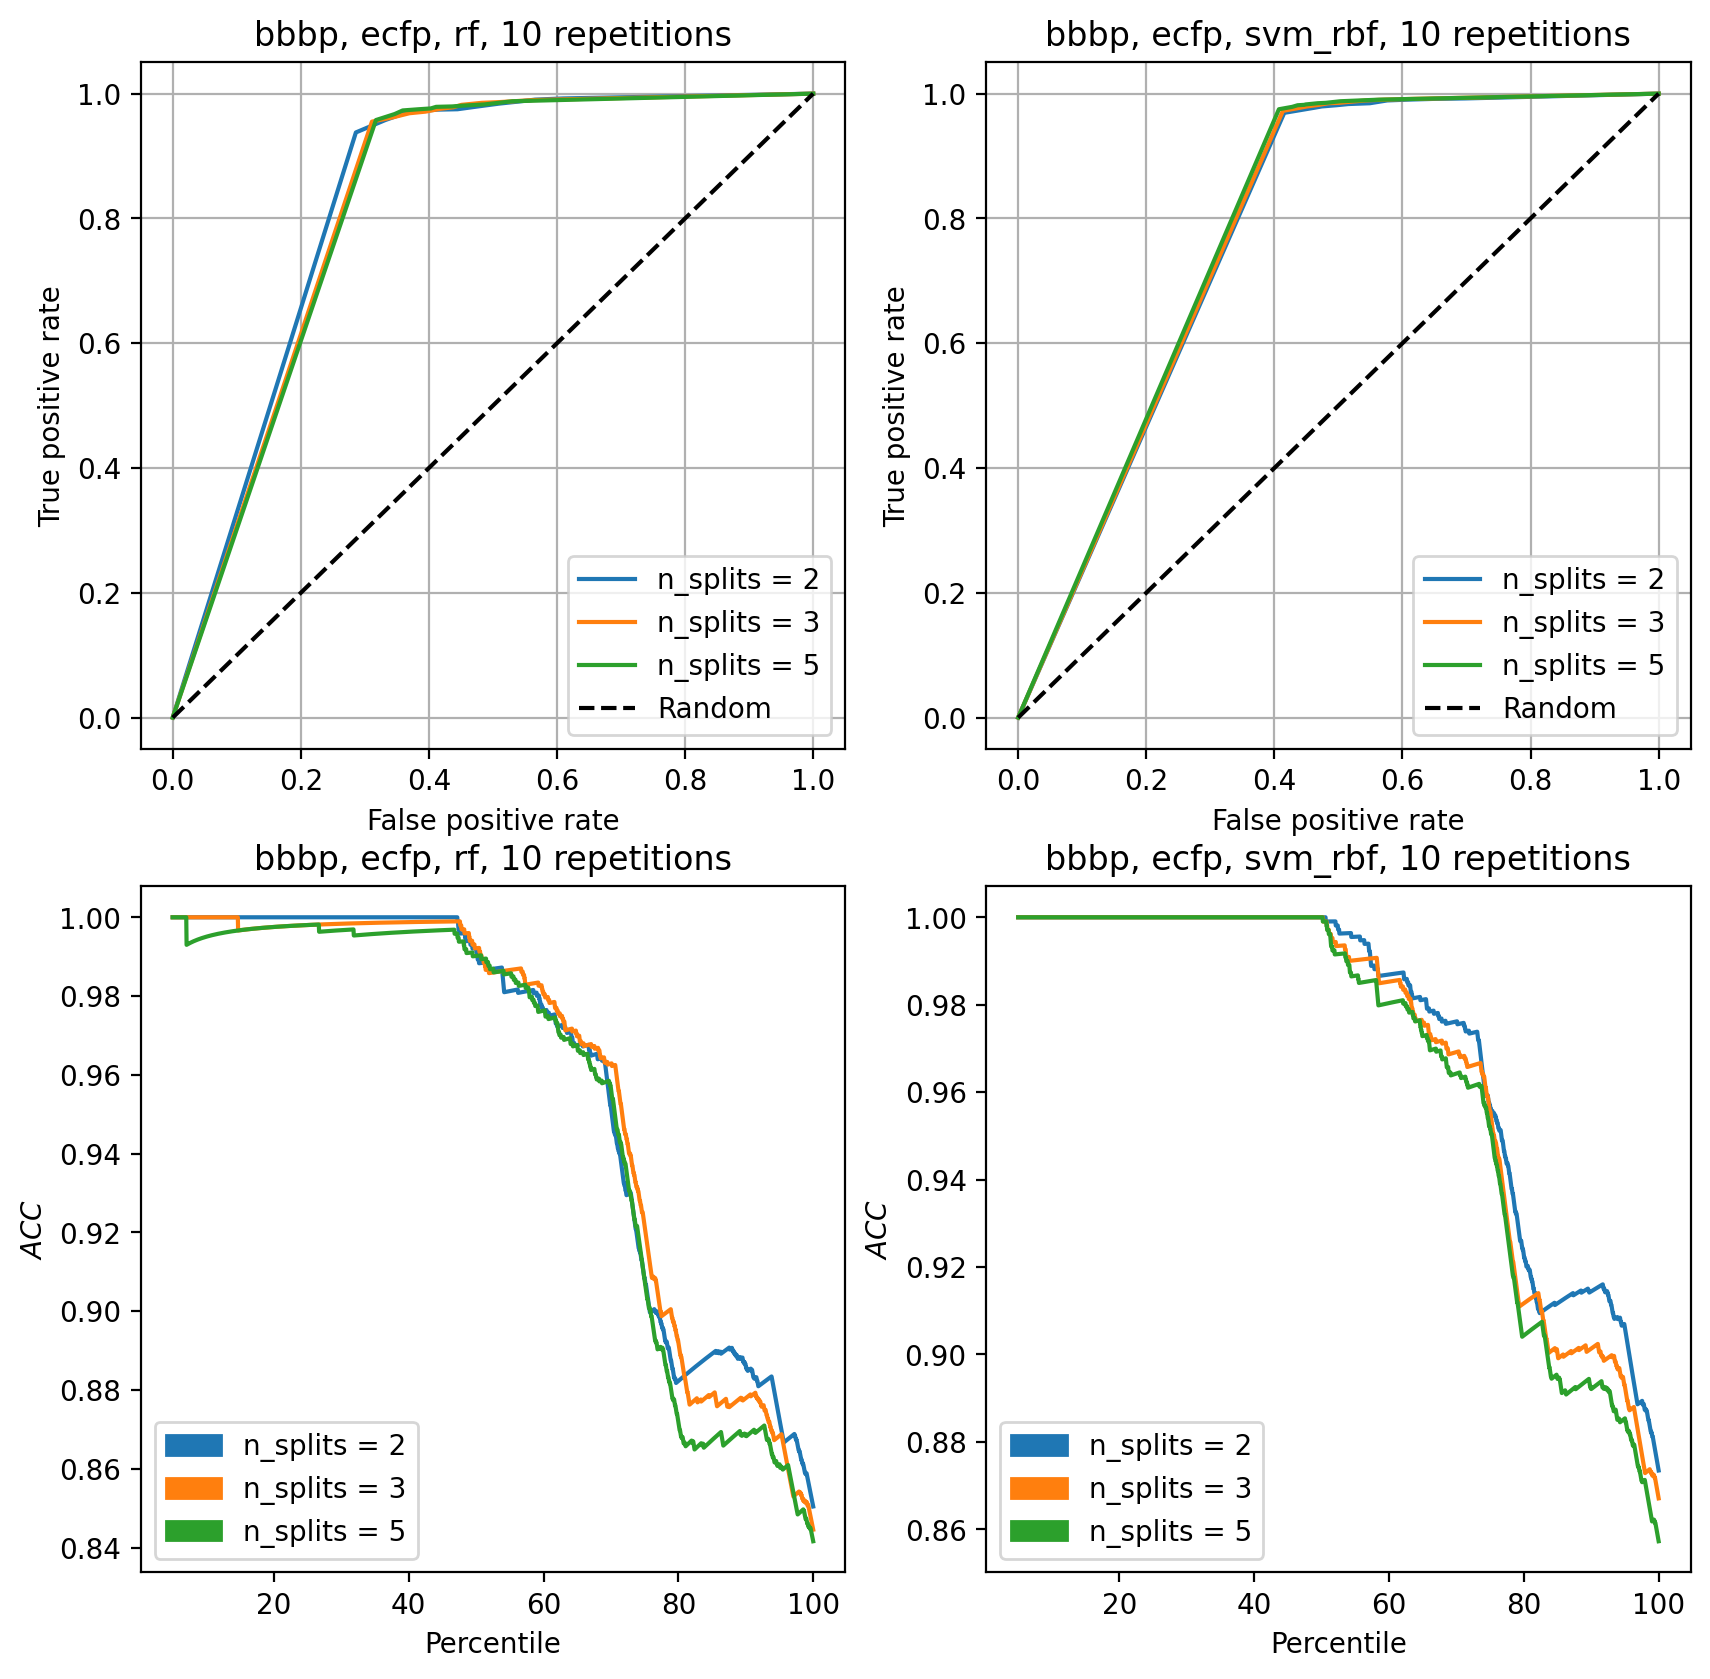

In [8]:
evaluation_automatization('bbbp', 'ecfp', ['rf', 'svm_rbf'], repetitions=10)

Repetition [1/3]


100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 15/15 [00:19<00:00,  1.29s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 15/15 [00:37<00:00,  2.49s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 15/15 [00:46<00:00,  3.13s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 15/15 [01:29<00:00,  6.00s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 15/15 [03:04<00:00, 12.33s/it]


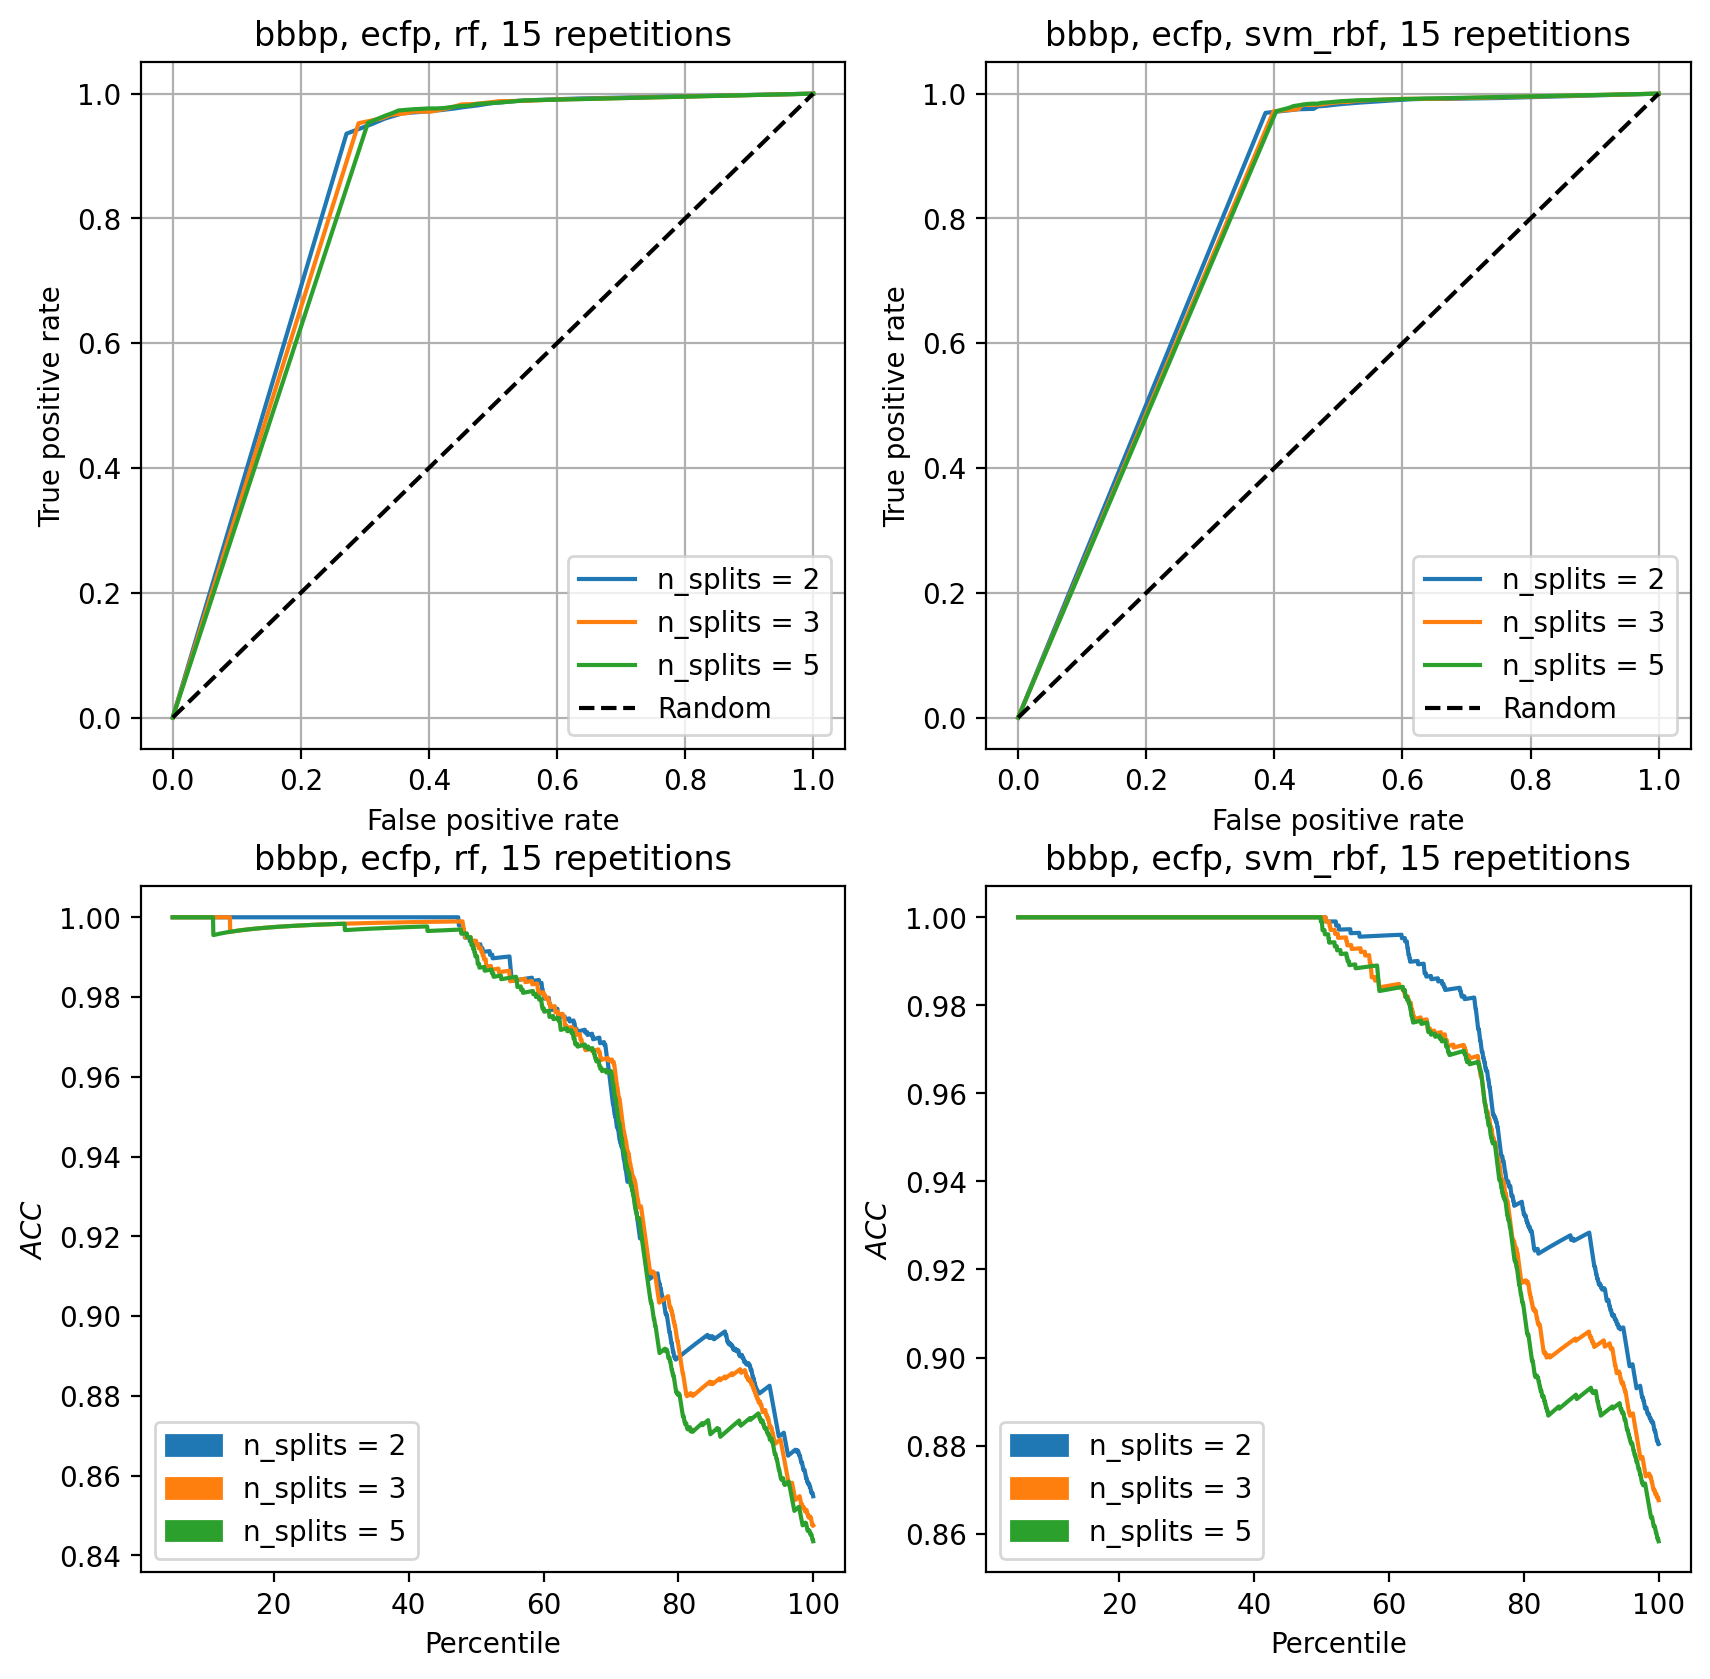

In [9]:
evaluation_automatization('bbbp', 'ecfp', ['rf', 'svm_rbf'], repetitions=15)

Repetition [1/3]


100%|███████████████████████████████████████████| 25/25 [00:17<00:00,  1.44it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 25/25 [00:31<00:00,  1.26s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 25/25 [01:00<00:00,  2.43s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 25/25 [01:17<00:00,  3.10s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 25/25 [02:30<00:00,  6.02s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 25/25 [04:58<00:00, 11.93s/it]


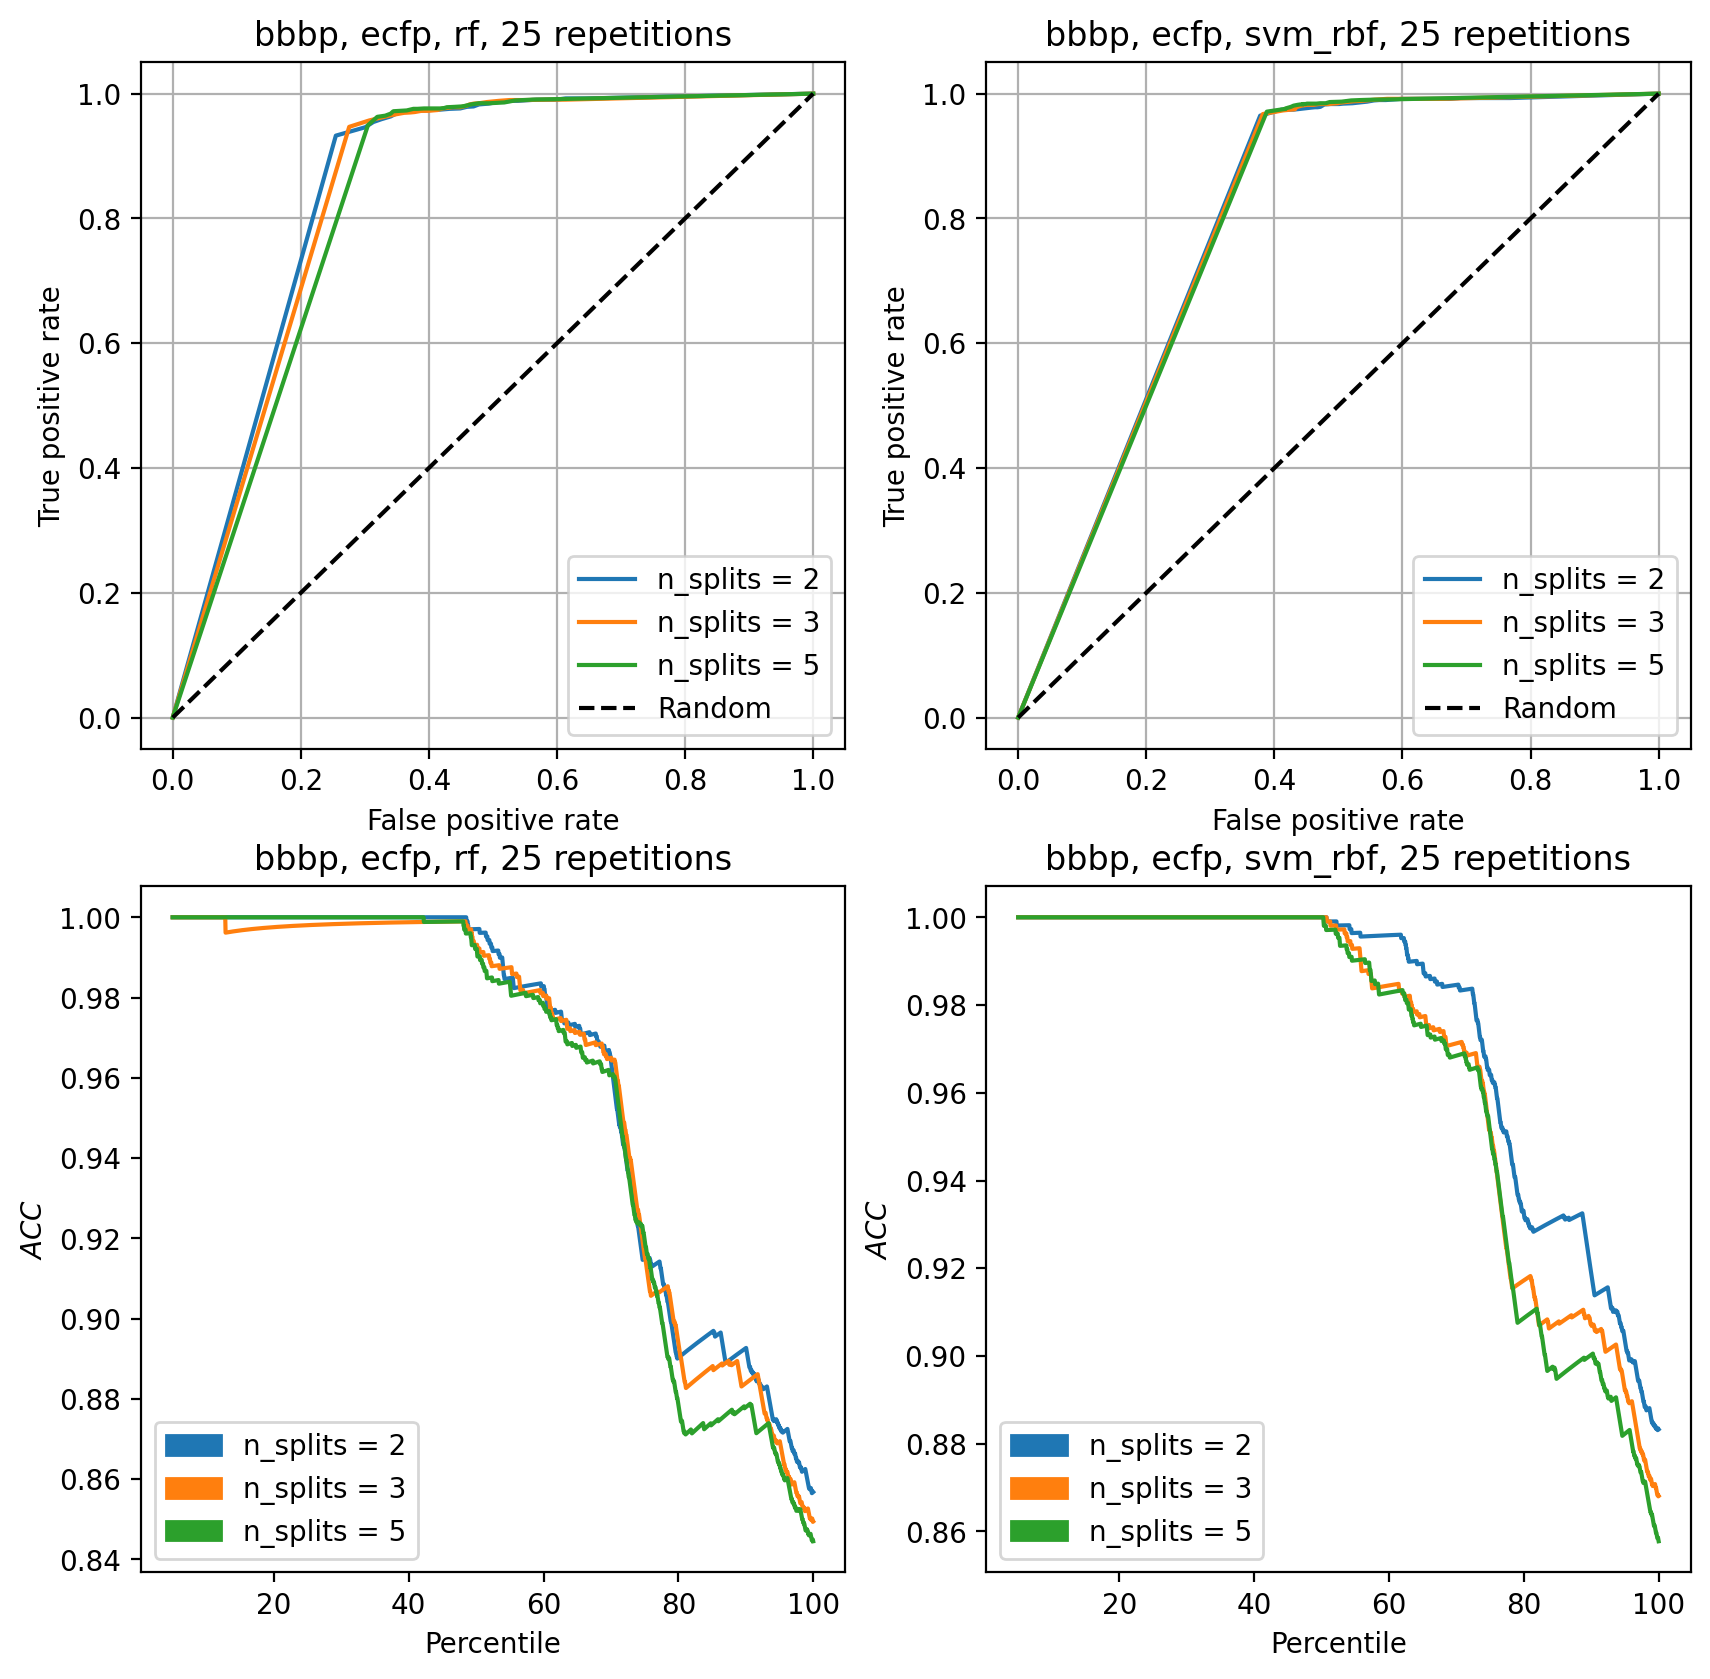

In [10]:
evaluation_automatization('bbbp', 'ecfp', ['rf', 'svm_rbf'], repetitions=25)

Repetition [1/3]


100%|███████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 50/50 [01:59<00:00,  2.39s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 50/50 [02:23<00:00,  2.87s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 50/50 [04:57<00:00,  5.96s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 50/50 [10:55<00:00, 13.10s/it]


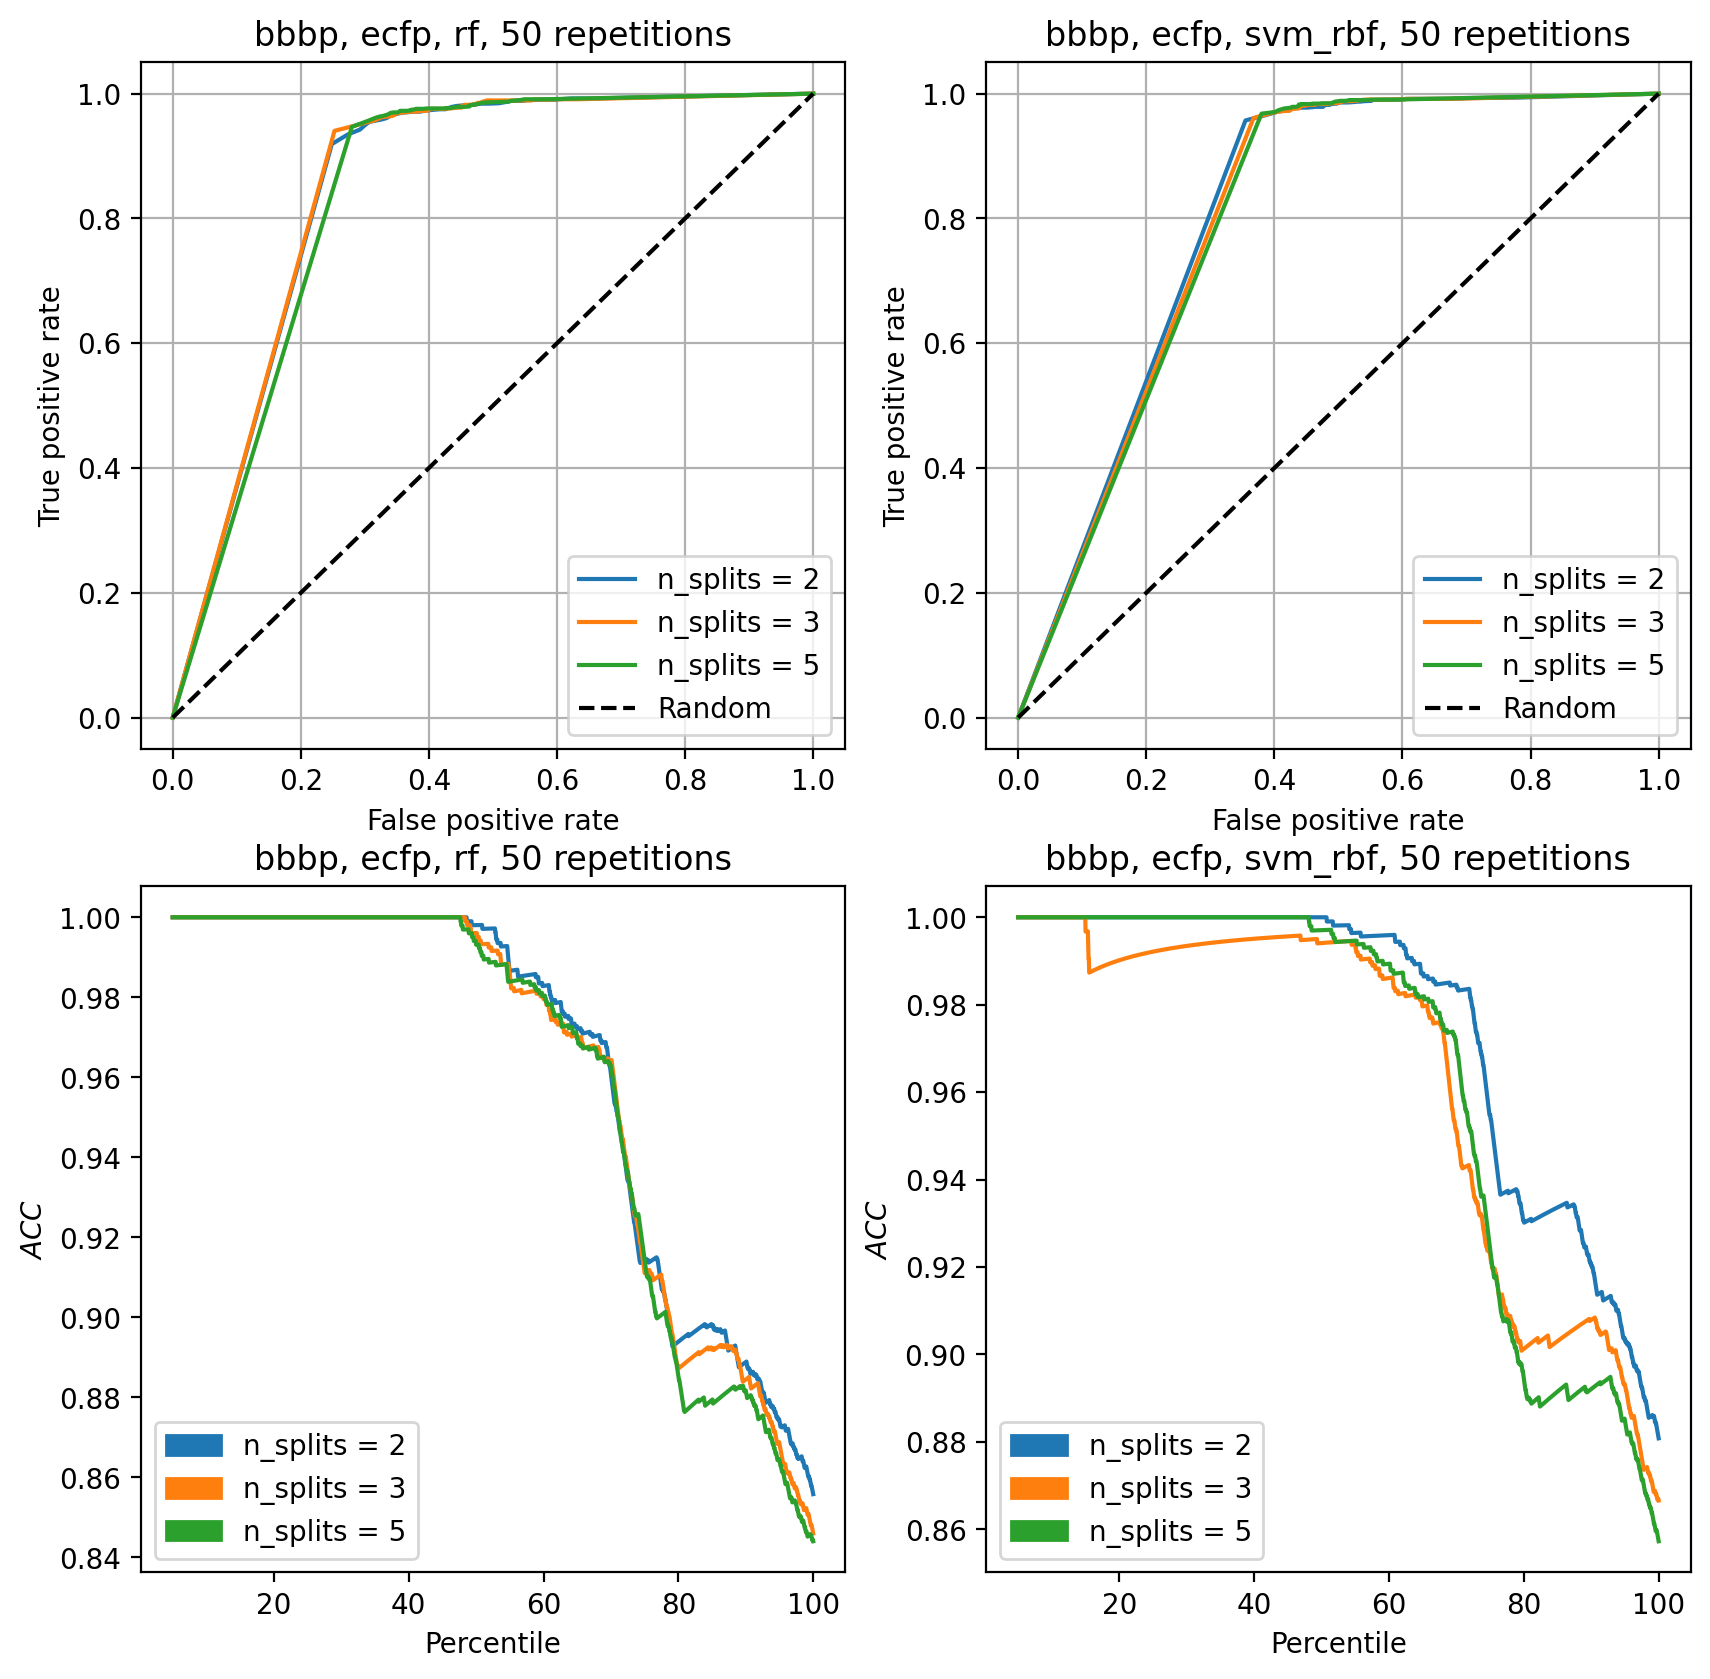

In [11]:
evaluation_automatization('bbbp', 'ecfp', ['rf', 'svm_rbf'], repetitions=50)

Repetition [1/3]


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Repetition [2/3]


100%|█████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


Repetition [3/3]


100%|█████████████████████████████████████████| 100/100 [04:18<00:00,  2.59s/it]


Repetition [1/3]


100%|█████████████████████████████████████████| 100/100 [04:50<00:00,  2.91s/it]


Repetition [2/3]


100%|█████████████████████████████████████████| 100/100 [10:07<00:00,  6.08s/it]


Repetition [3/3]


100%|█████████████████████████████████████████| 100/100 [21:09<00:00, 12.70s/it]


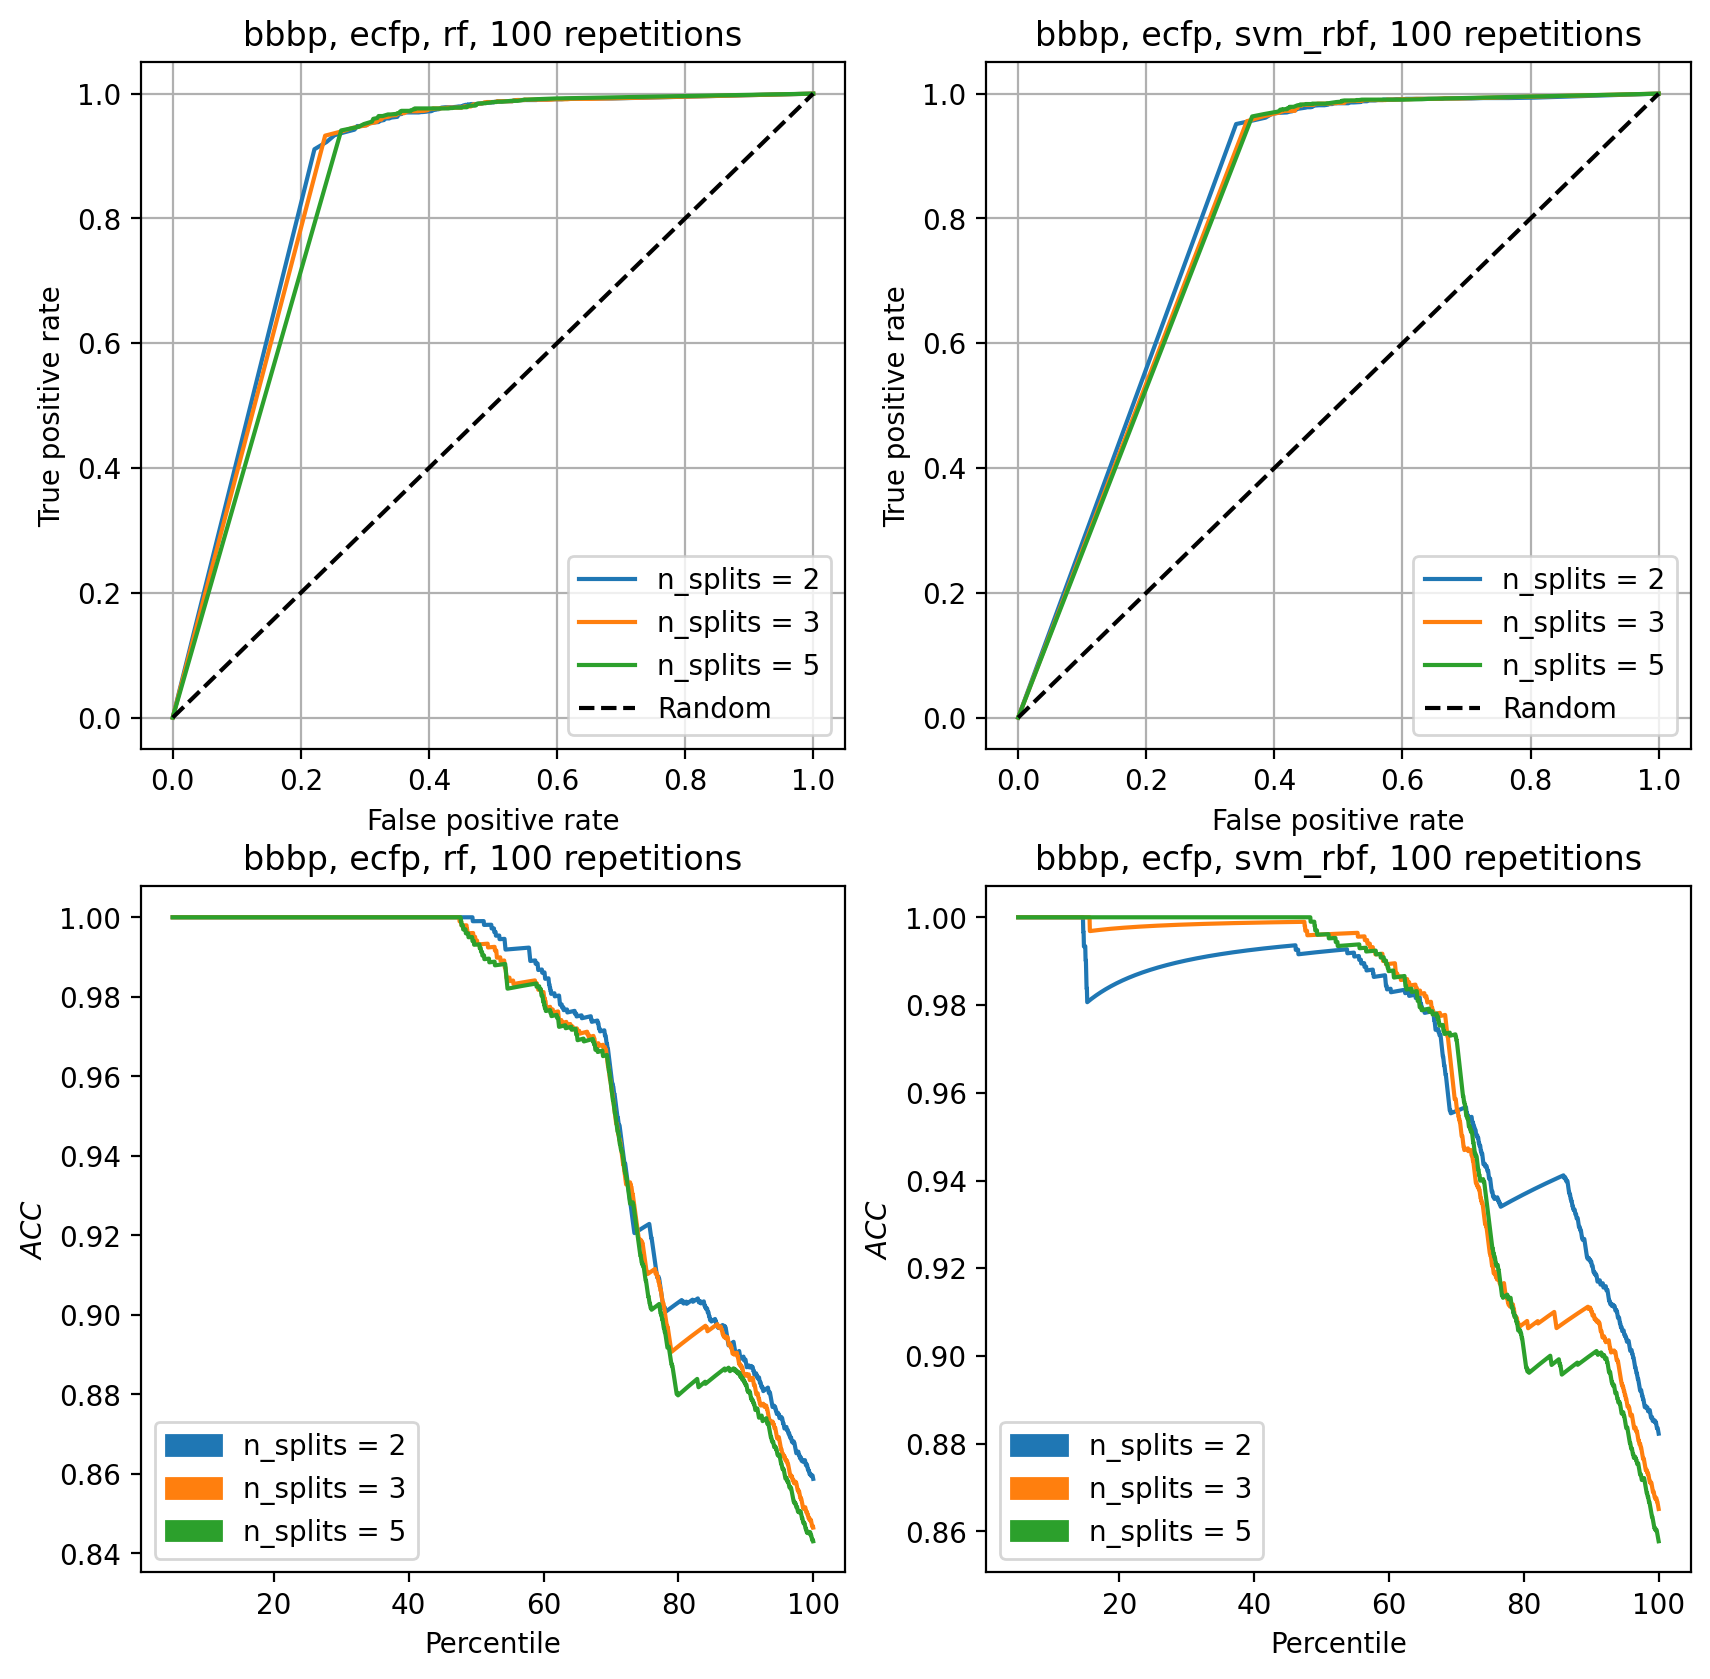

In [12]:
evaluation_automatization('bbbp', 'ecfp', ['rf', 'svm_rbf'], repetitions=100)

#### Testing repetitions bace:

Repetition [1/3]


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Repetition [2/3]


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


Repetition [3/3]


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.73s/it]


Repetition [1/3]


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.83s/it]


Repetition [2/3]


100%|█████████████████████████████████████████████| 3/3 [00:11<00:00,  3.87s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 3/3 [00:24<00:00,  8.24s/it]


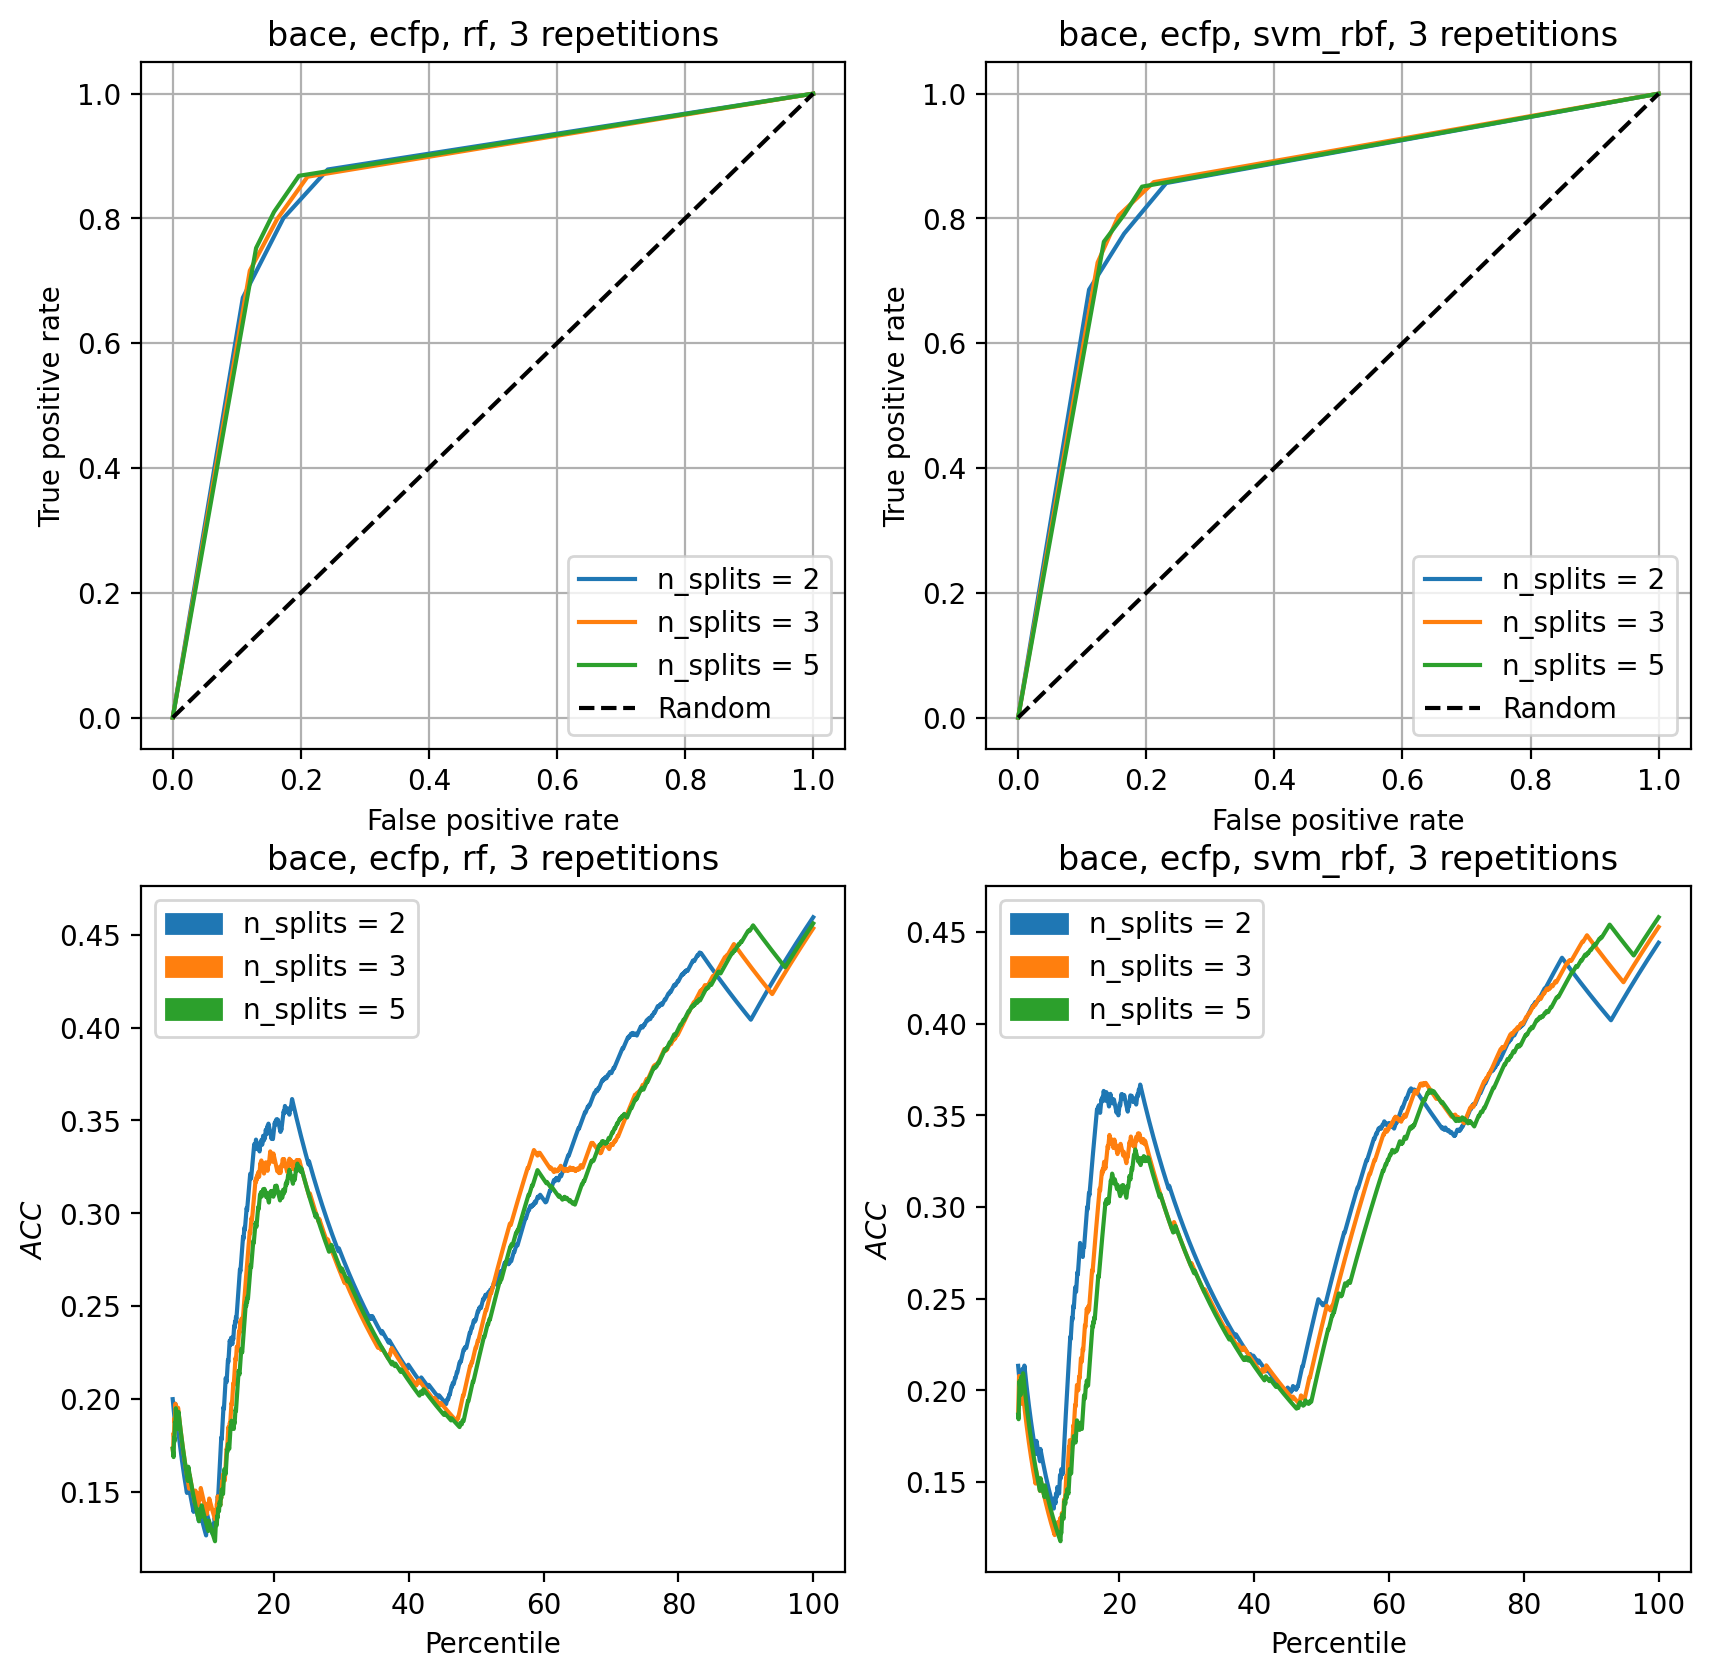

In [13]:
evaluation_automatization('bace', 'ecfp', ['rf', 'svm_rbf'], repetitions=3)

Repetition [1/3]


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


Repetition [2/3]


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


Repetition [3/3]


100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.77s/it]


Repetition [1/3]


100%|█████████████████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it]


Repetition [2/3]


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.84s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 5/5 [00:40<00:00,  8.06s/it]


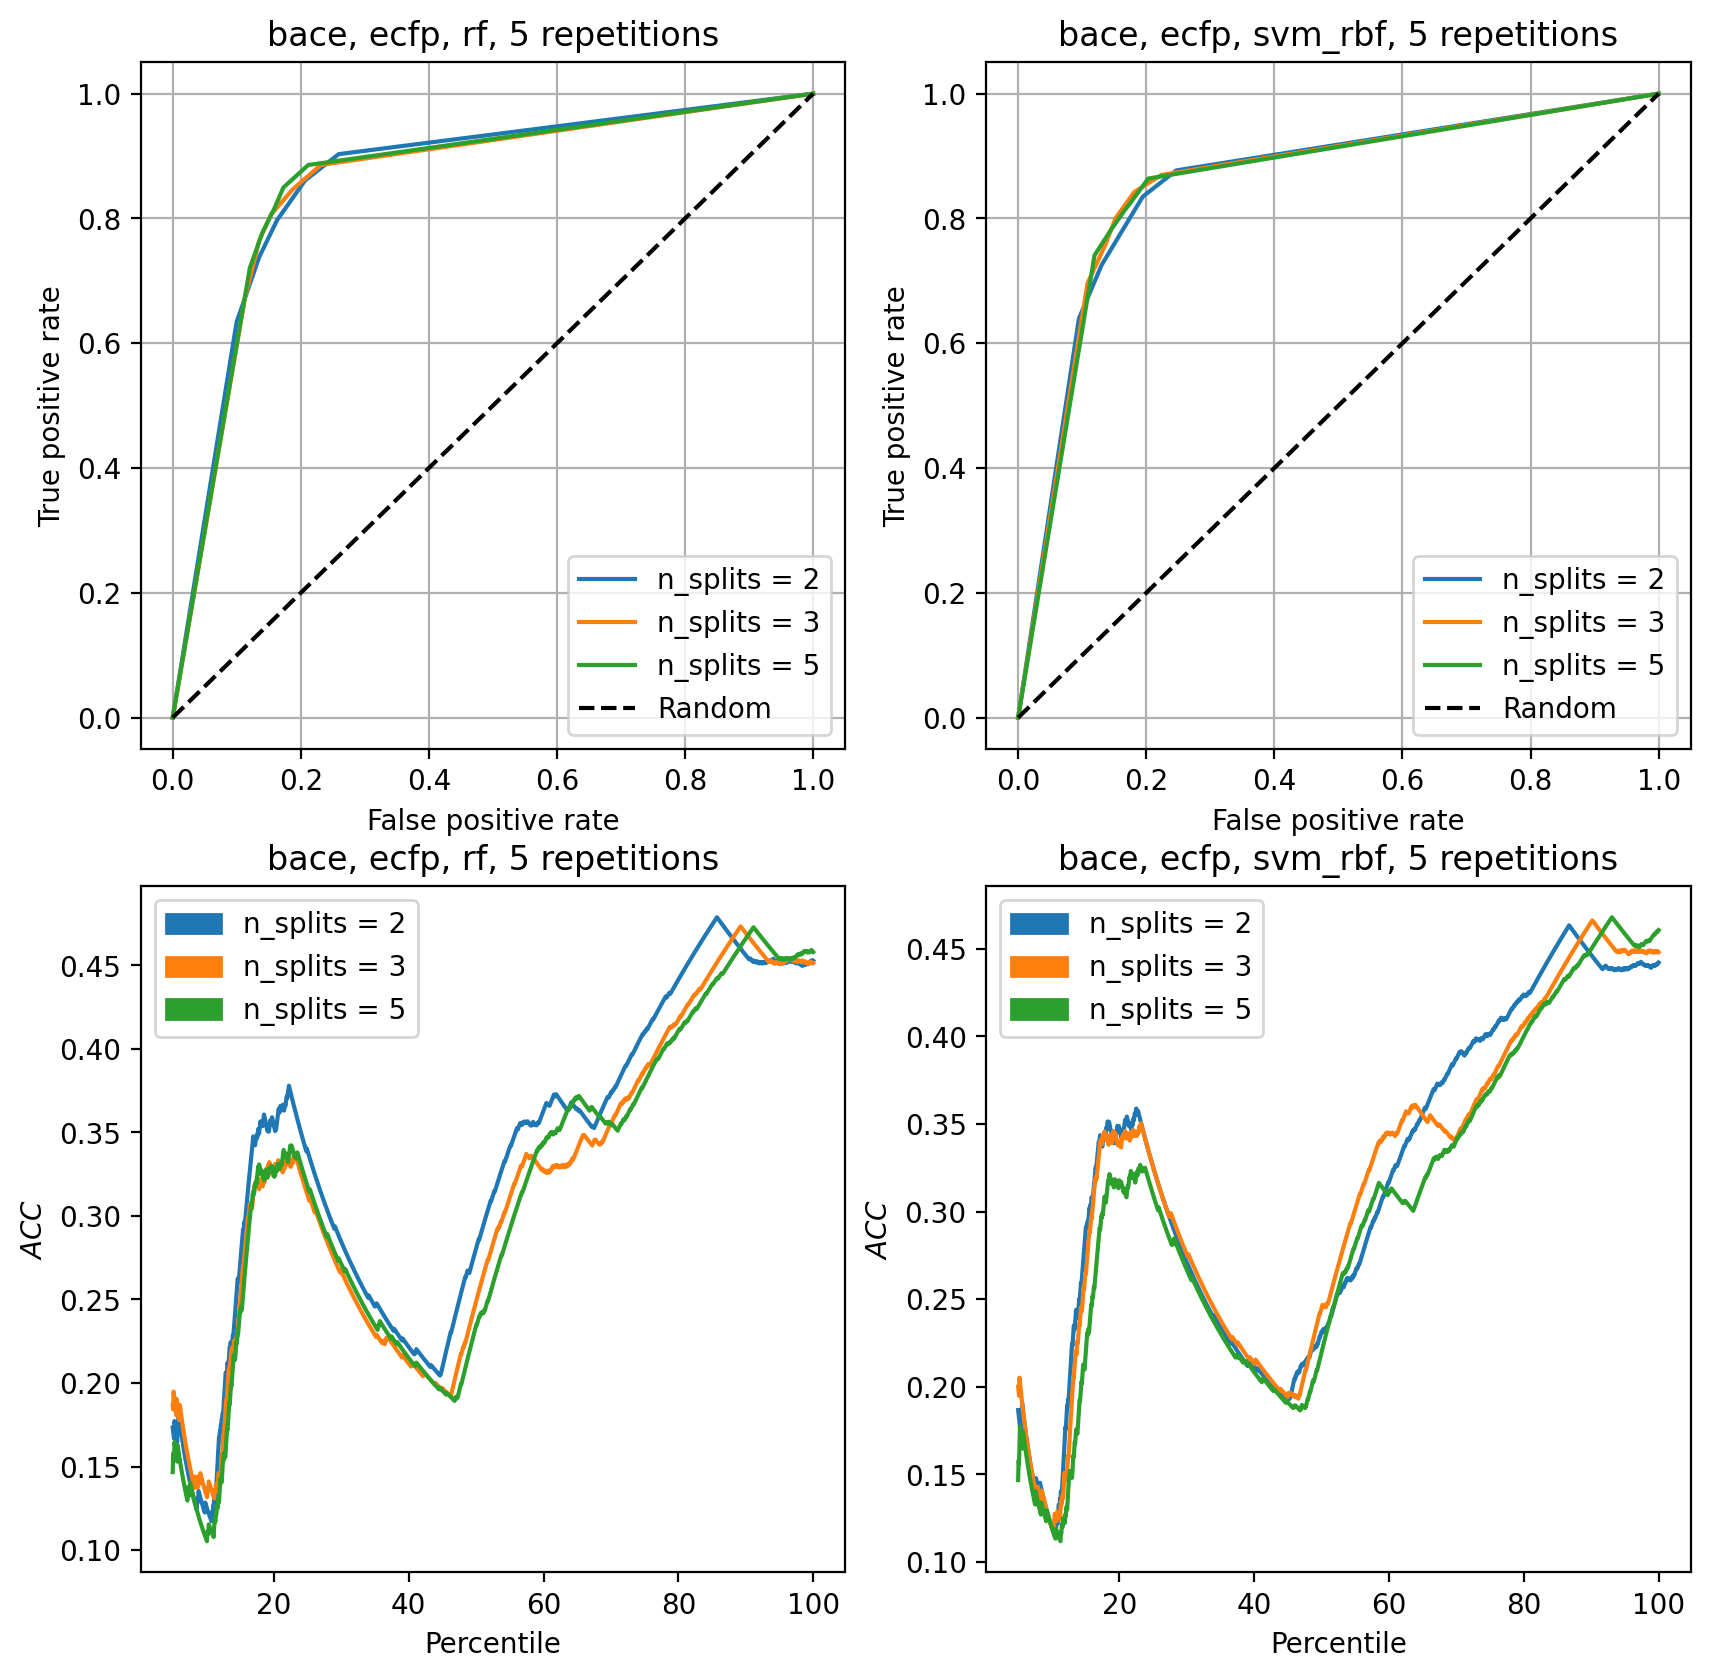

In [14]:
evaluation_automatization('bace', 'ecfp', ['rf', 'svm_rbf'], repetitions=5)

Repetition [1/3]


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.93it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s]


Repetition [3/3]


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.87s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 10/10 [01:16<00:00,  7.63s/it]


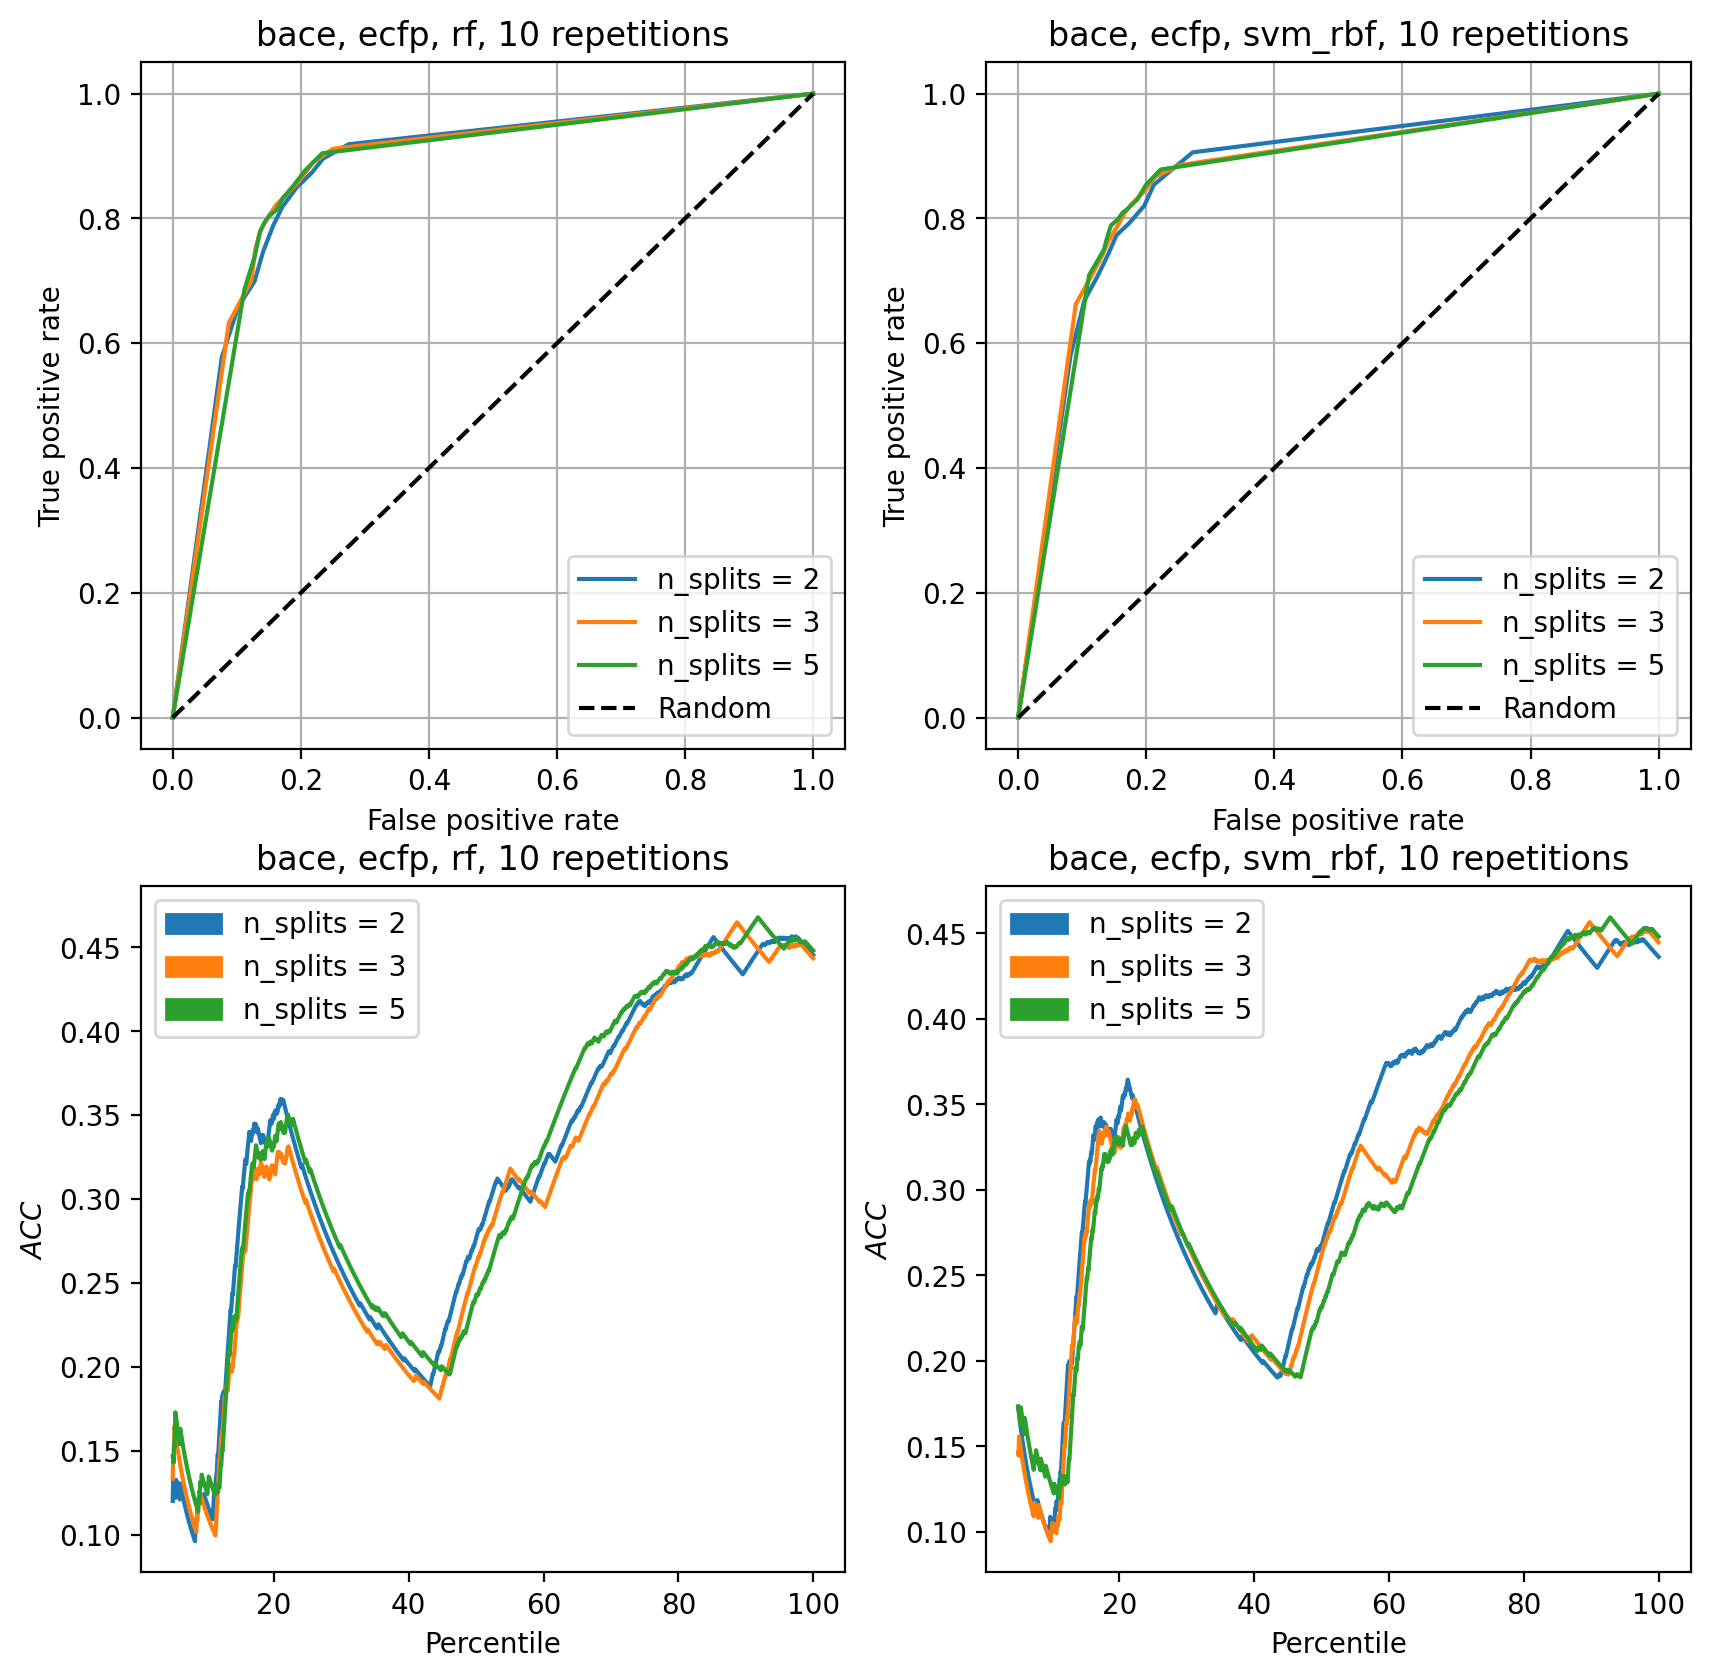

In [15]:
evaluation_automatization('bace', 'ecfp', ['rf', 'svm_rbf'], repetitions=10)

Repetition [1/3]


100%|███████████████████████████████████████████| 15/15 [00:07<00:00,  2.02it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.12it/s]


Repetition [3/3]


100%|███████████████████████████████████████████| 15/15 [00:25<00:00,  1.70s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 15/15 [00:27<00:00,  1.84s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 15/15 [00:56<00:00,  3.79s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 15/15 [01:54<00:00,  7.65s/it]


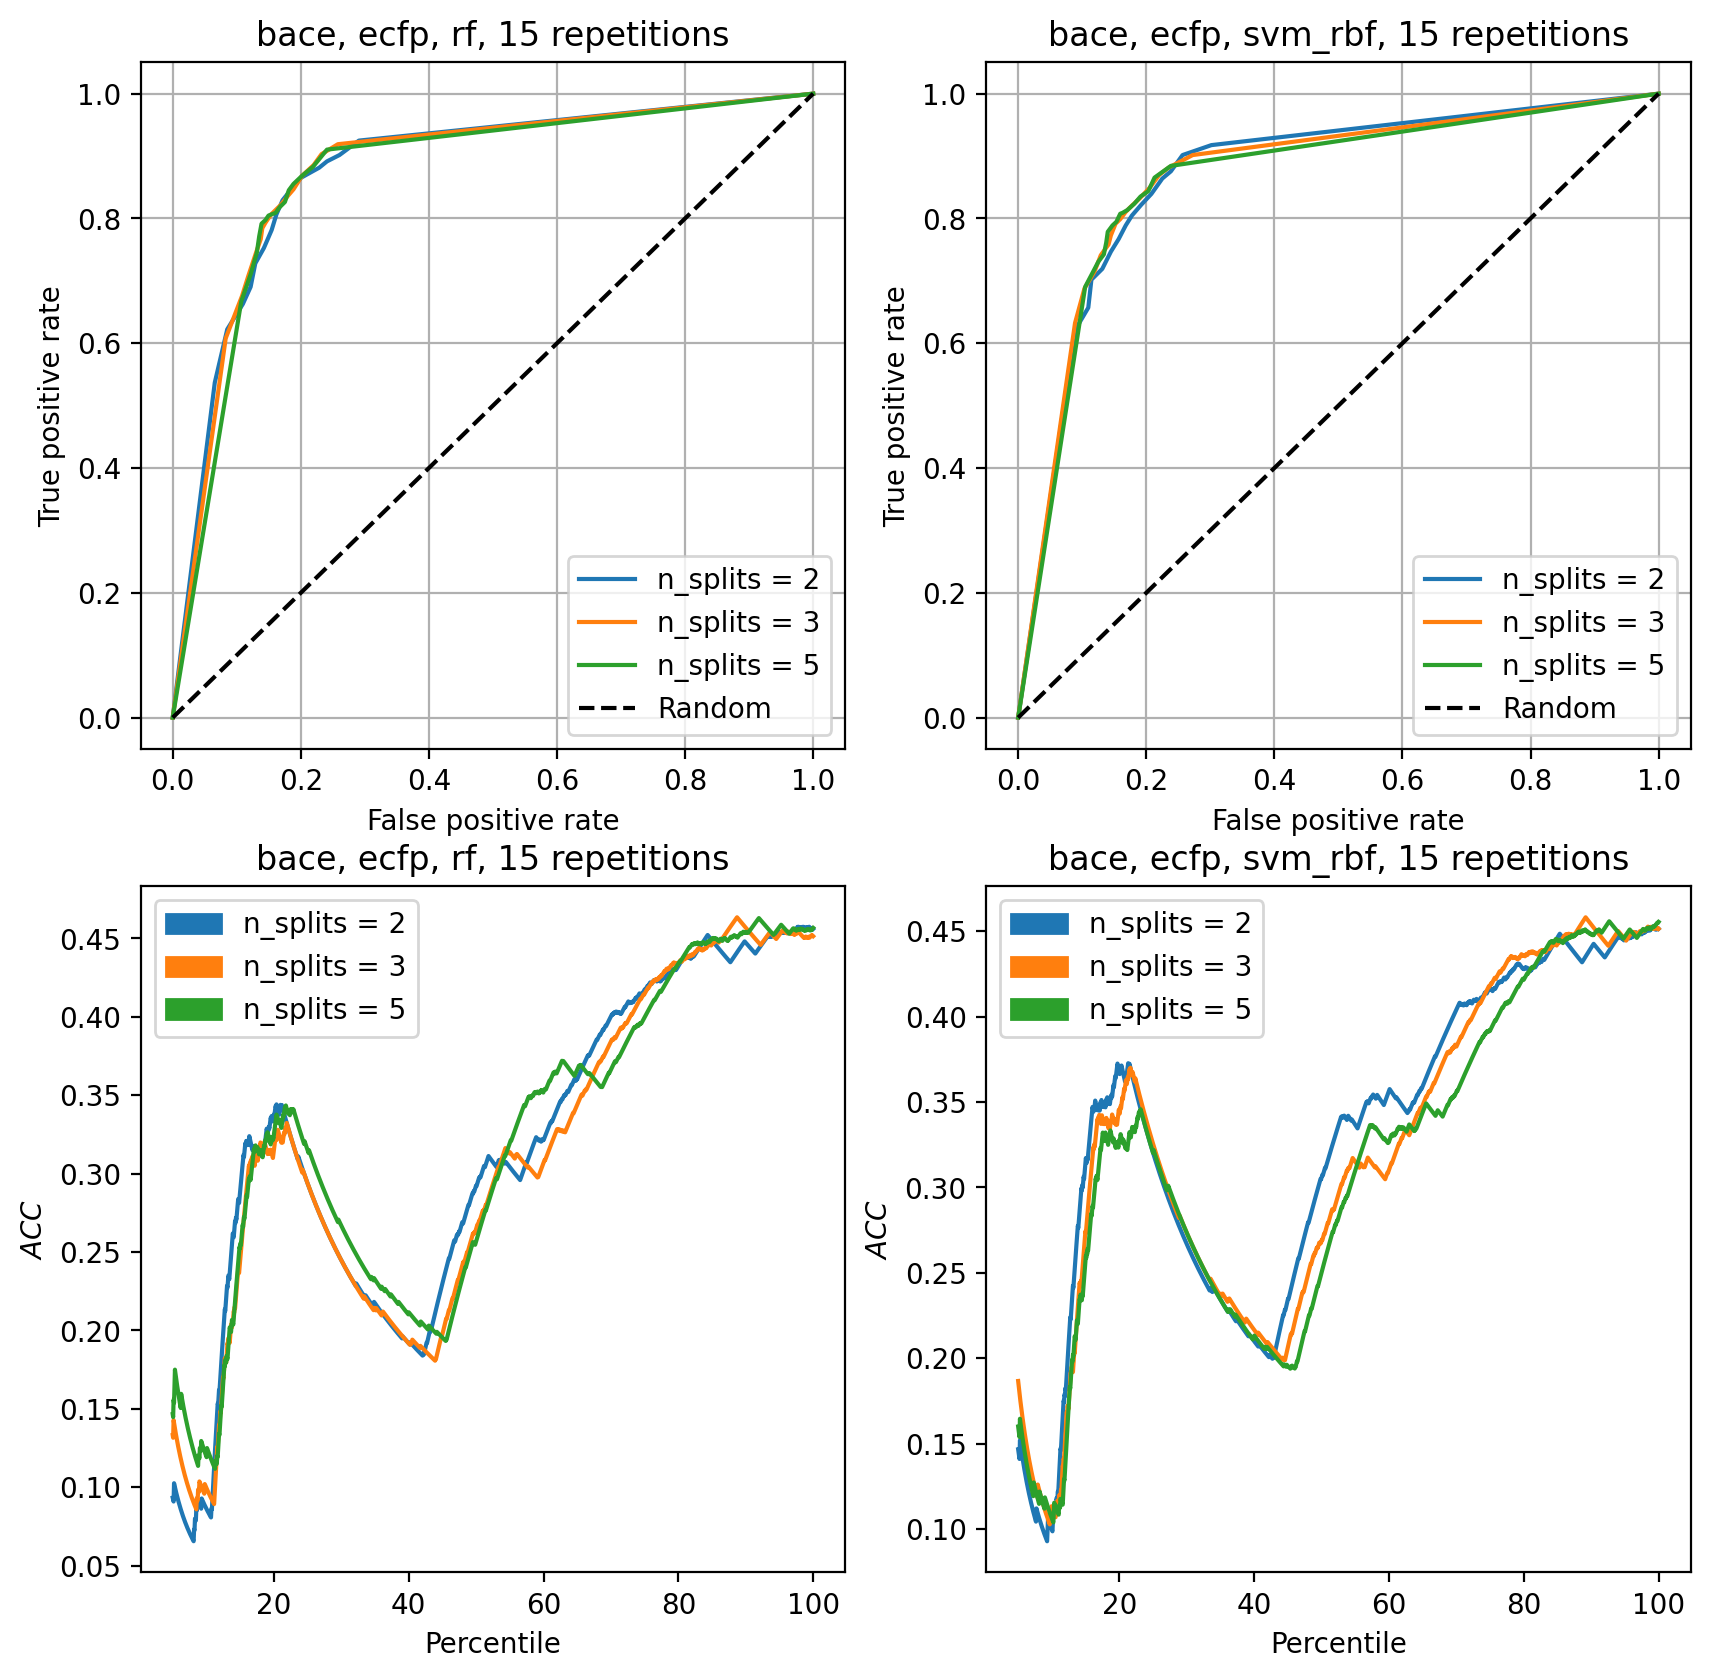

In [16]:
evaluation_automatization('bace', 'ecfp', ['rf', 'svm_rbf'], repetitions=15)

Repetition [1/3]


100%|███████████████████████████████████████████| 25/25 [00:12<00:00,  2.02it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 25/25 [00:22<00:00,  1.11it/s]


Repetition [3/3]


100%|███████████████████████████████████████████| 25/25 [00:42<00:00,  1.71s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 25/25 [00:47<00:00,  1.88s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 25/25 [01:34<00:00,  3.77s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 25/25 [03:15<00:00,  7.83s/it]


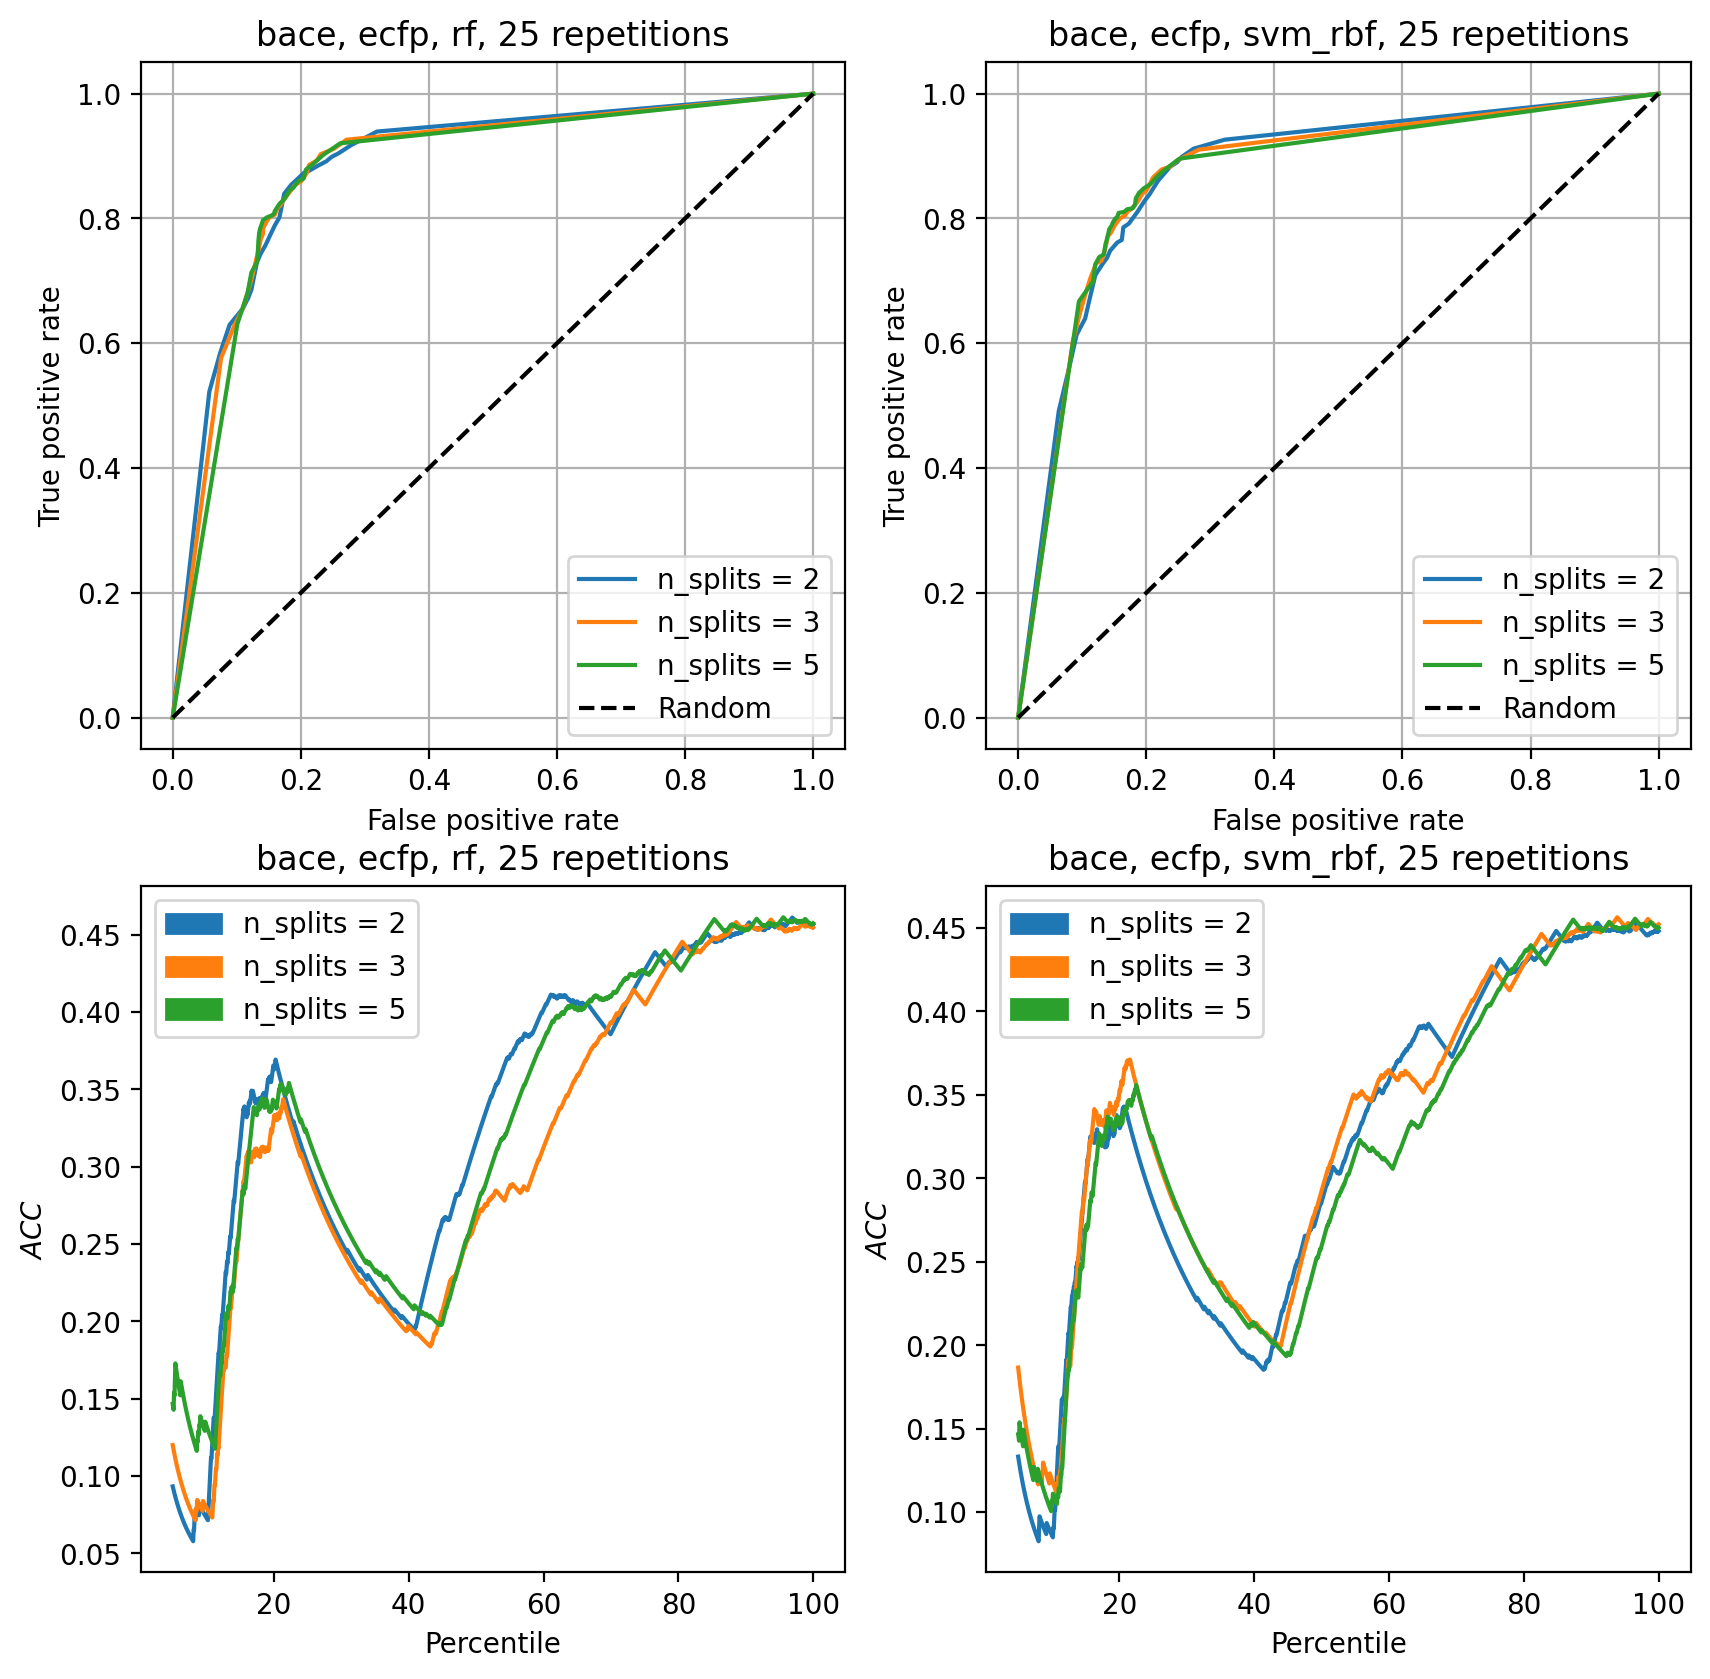

In [17]:
evaluation_automatization('bace', 'ecfp', ['rf', 'svm_rbf'], repetitions=25)

Repetition [1/3]


100%|███████████████████████████████████████████| 50/50 [00:24<00:00,  2.00it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


Repetition [3/3]


100%|███████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 50/50 [03:08<00:00,  3.77s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 50/50 [06:29<00:00,  7.79s/it]


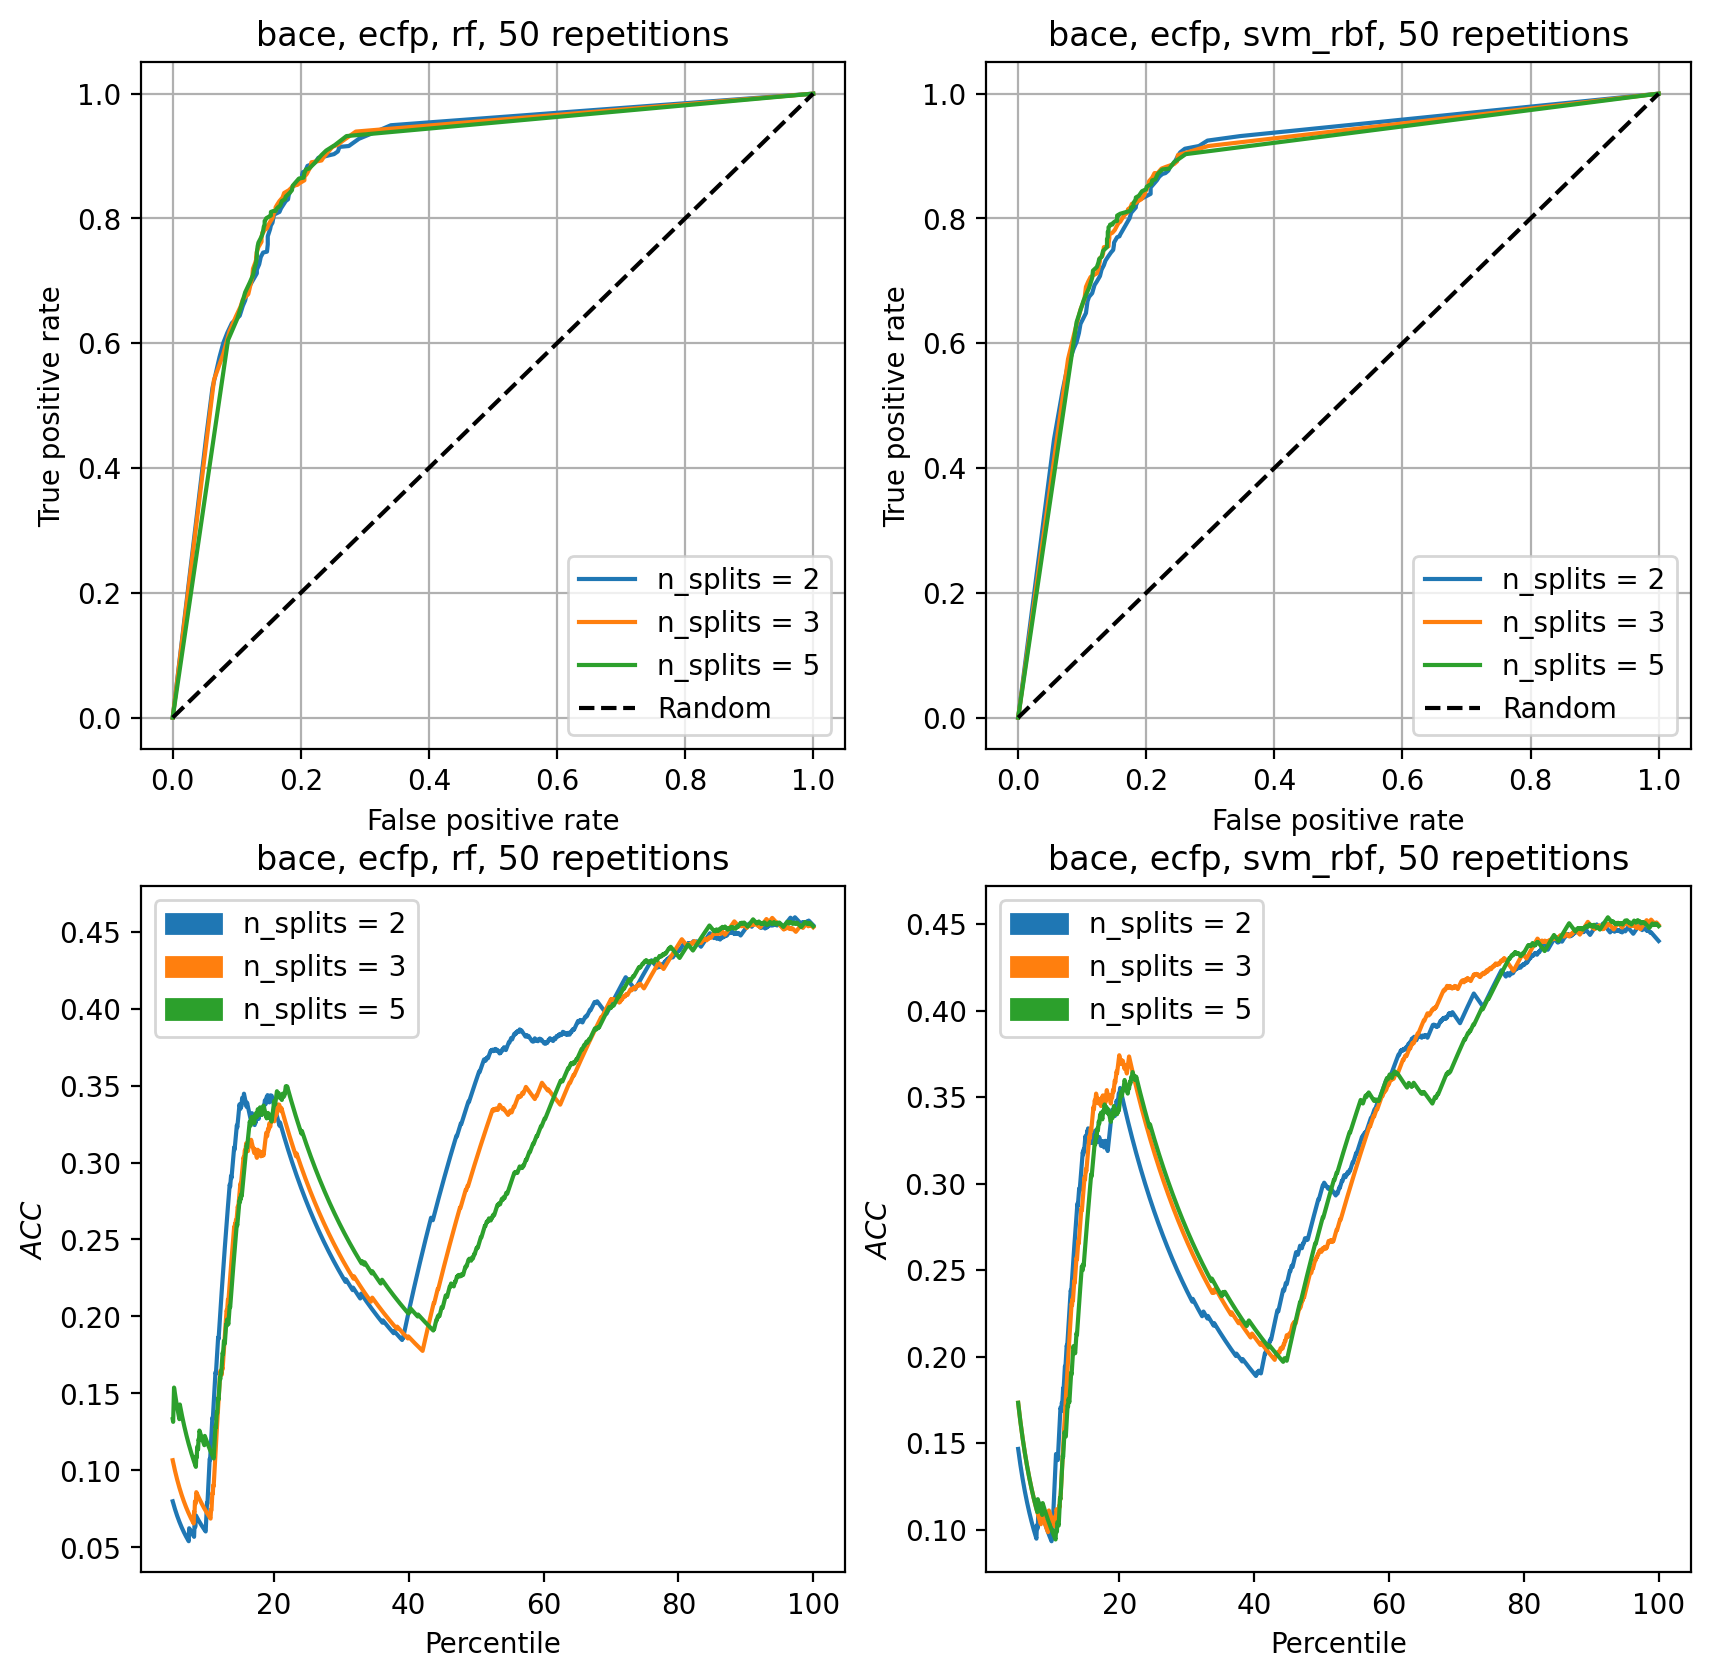

In [18]:
evaluation_automatization('bace', 'ecfp', ['rf', 'svm_rbf'], repetitions=50)

Repetition [1/3]


100%|█████████████████████████████████████████| 100/100 [00:50<00:00,  1.96it/s]


Repetition [2/3]


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Repetition [3/3]


100%|█████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


Repetition [1/3]


100%|█████████████████████████████████████████| 100/100 [03:04<00:00,  1.84s/it]


Repetition [2/3]


100%|█████████████████████████████████████████| 100/100 [06:23<00:00,  3.83s/it]


Repetition [3/3]


100%|█████████████████████████████████████████| 100/100 [13:16<00:00,  7.97s/it]


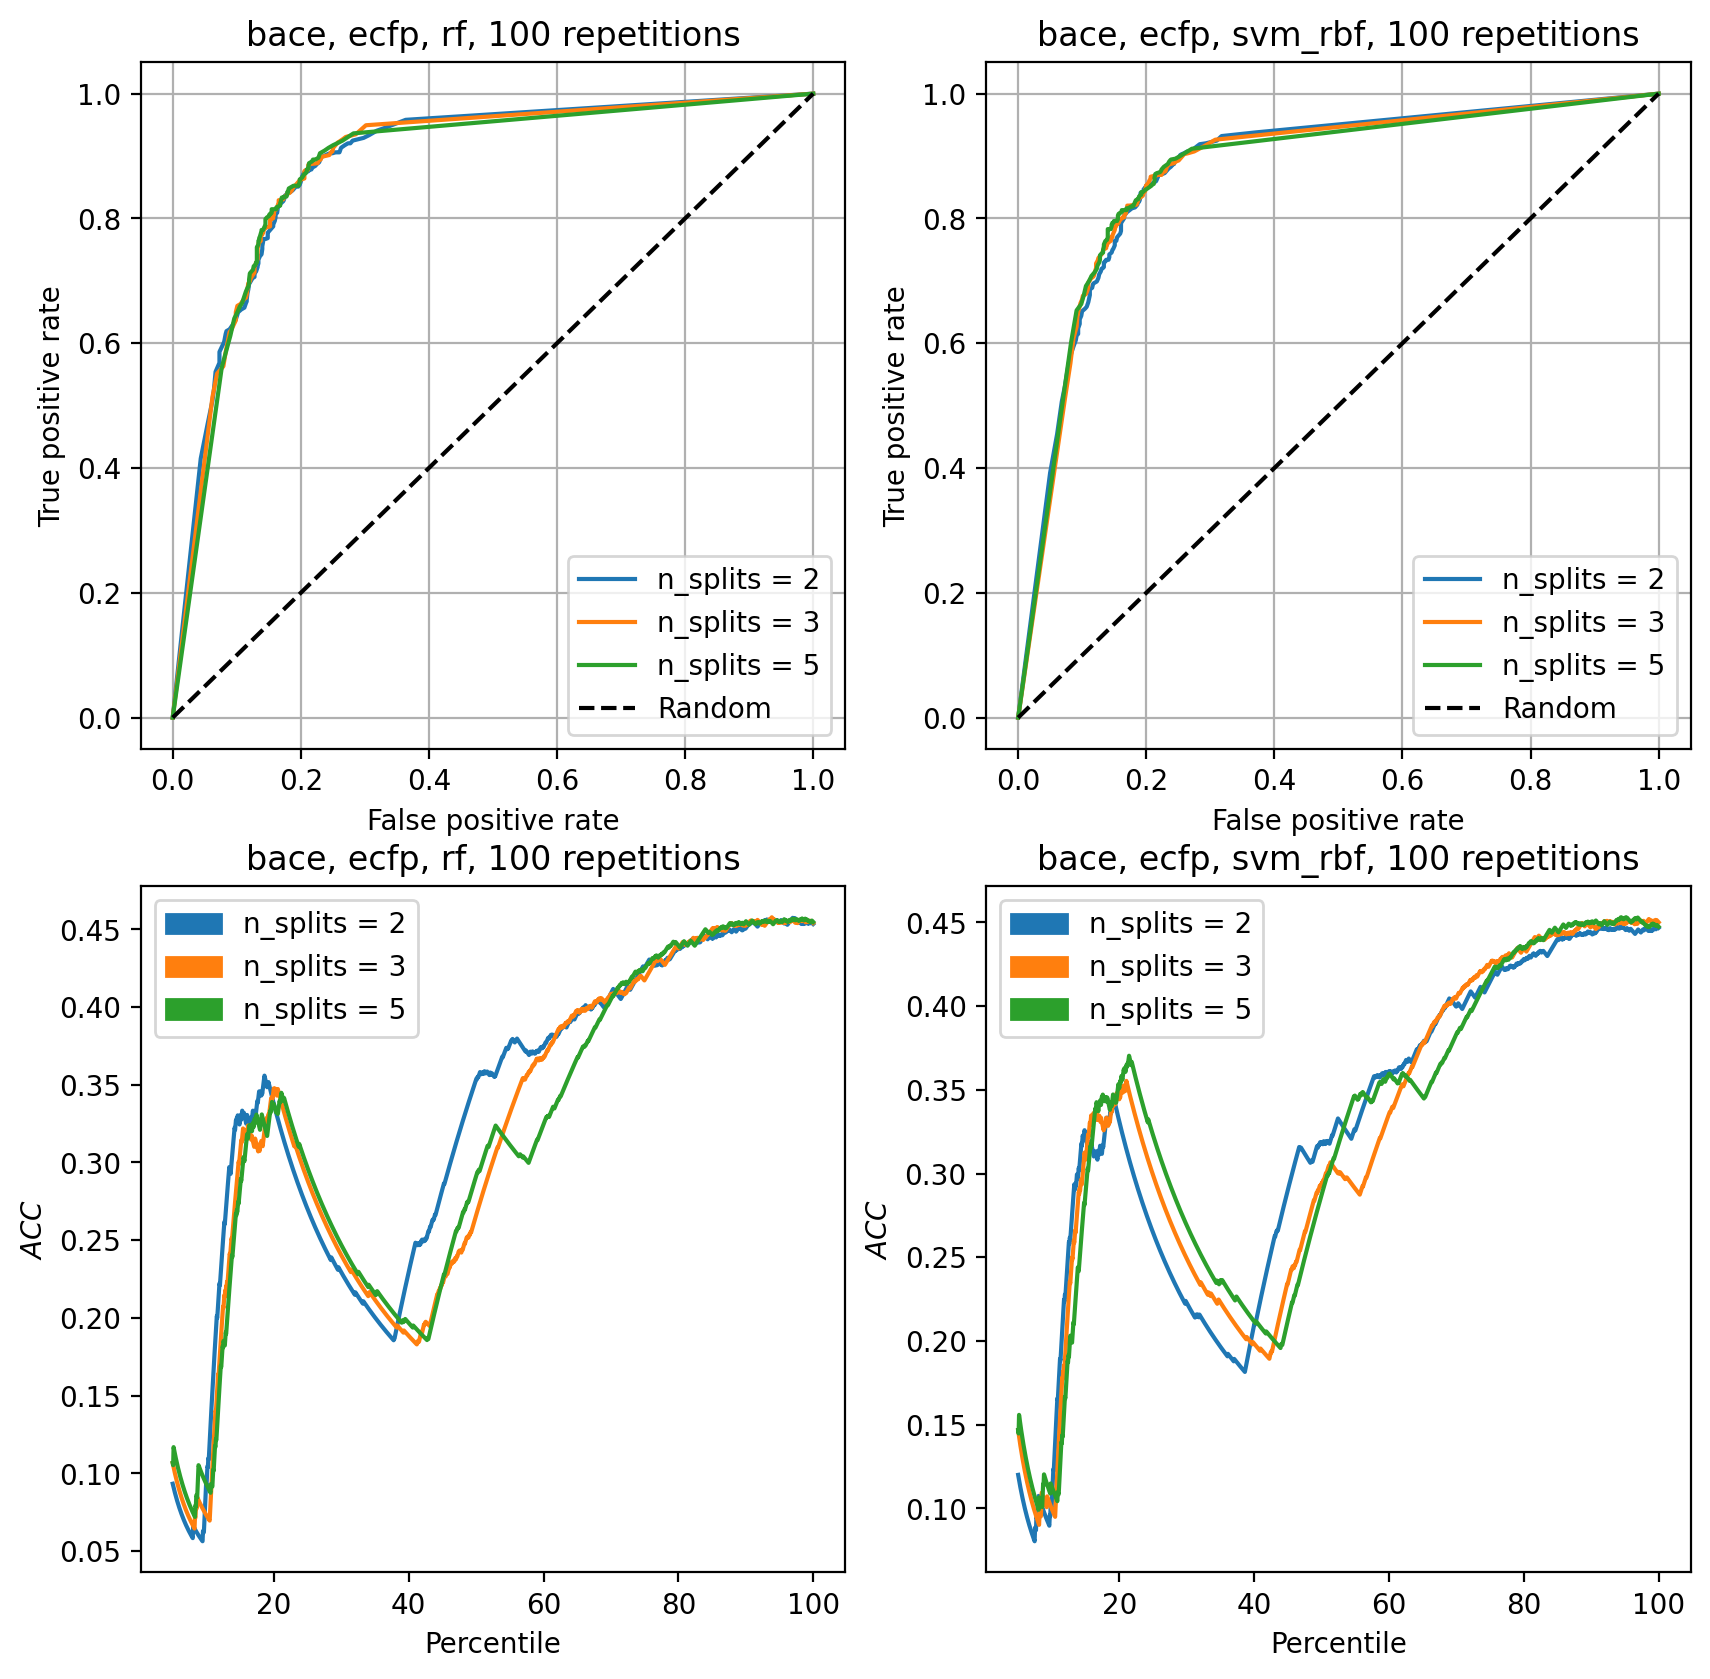

In [19]:
evaluation_automatization('bace', 'ecfp', ['rf', 'svm_rbf'], repetitions=100)

#### Testing repetitions hERG3:

Repetition [1/3]


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Repetition [2/3]


100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.56s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 3/3 [00:09<00:00,  3.17s/it]


Repetition [1/3]


100%|█████████████████████████████████████████████| 3/3 [00:16<00:00,  5.33s/it]


Repetition [2/3]


100%|█████████████████████████████████████████████| 3/3 [00:38<00:00, 12.73s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 3/3 [01:32<00:00, 30.93s/it]


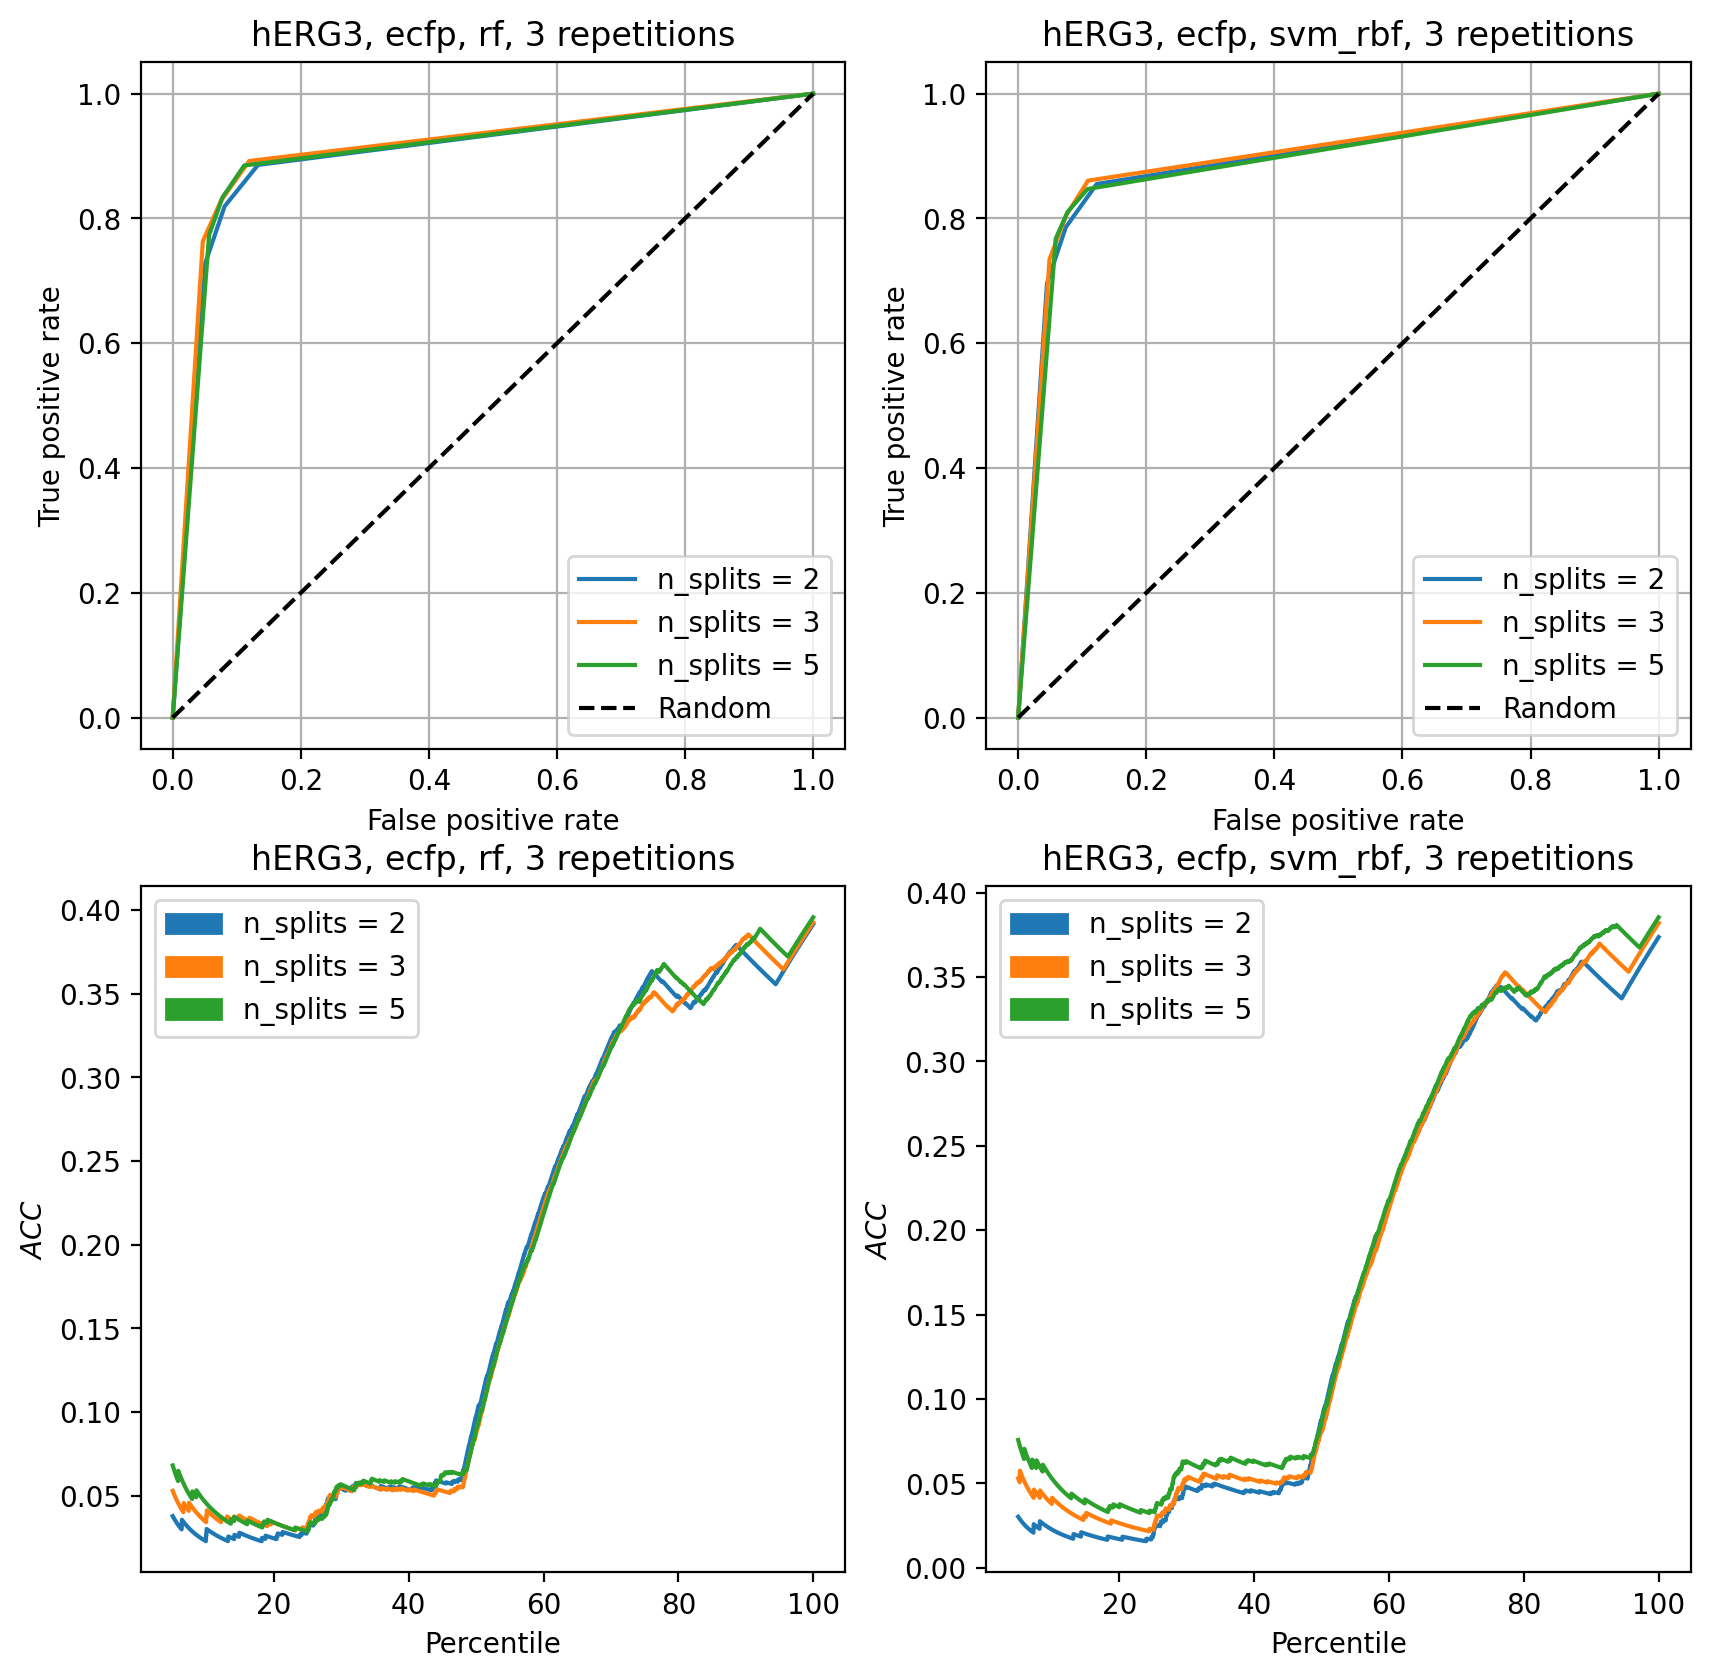

In [20]:
evaluation_automatization('hERG3', 'ecfp', ['rf', 'svm_rbf'], repetitions=3)

Repetition [1/3]


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


Repetition [2/3]


100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 5/5 [00:16<00:00,  3.22s/it]


Repetition [1/3]


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.41s/it]


Repetition [2/3]


100%|█████████████████████████████████████████████| 5/5 [01:02<00:00, 12.49s/it]


Repetition [3/3]


100%|█████████████████████████████████████████████| 5/5 [02:31<00:00, 30.24s/it]


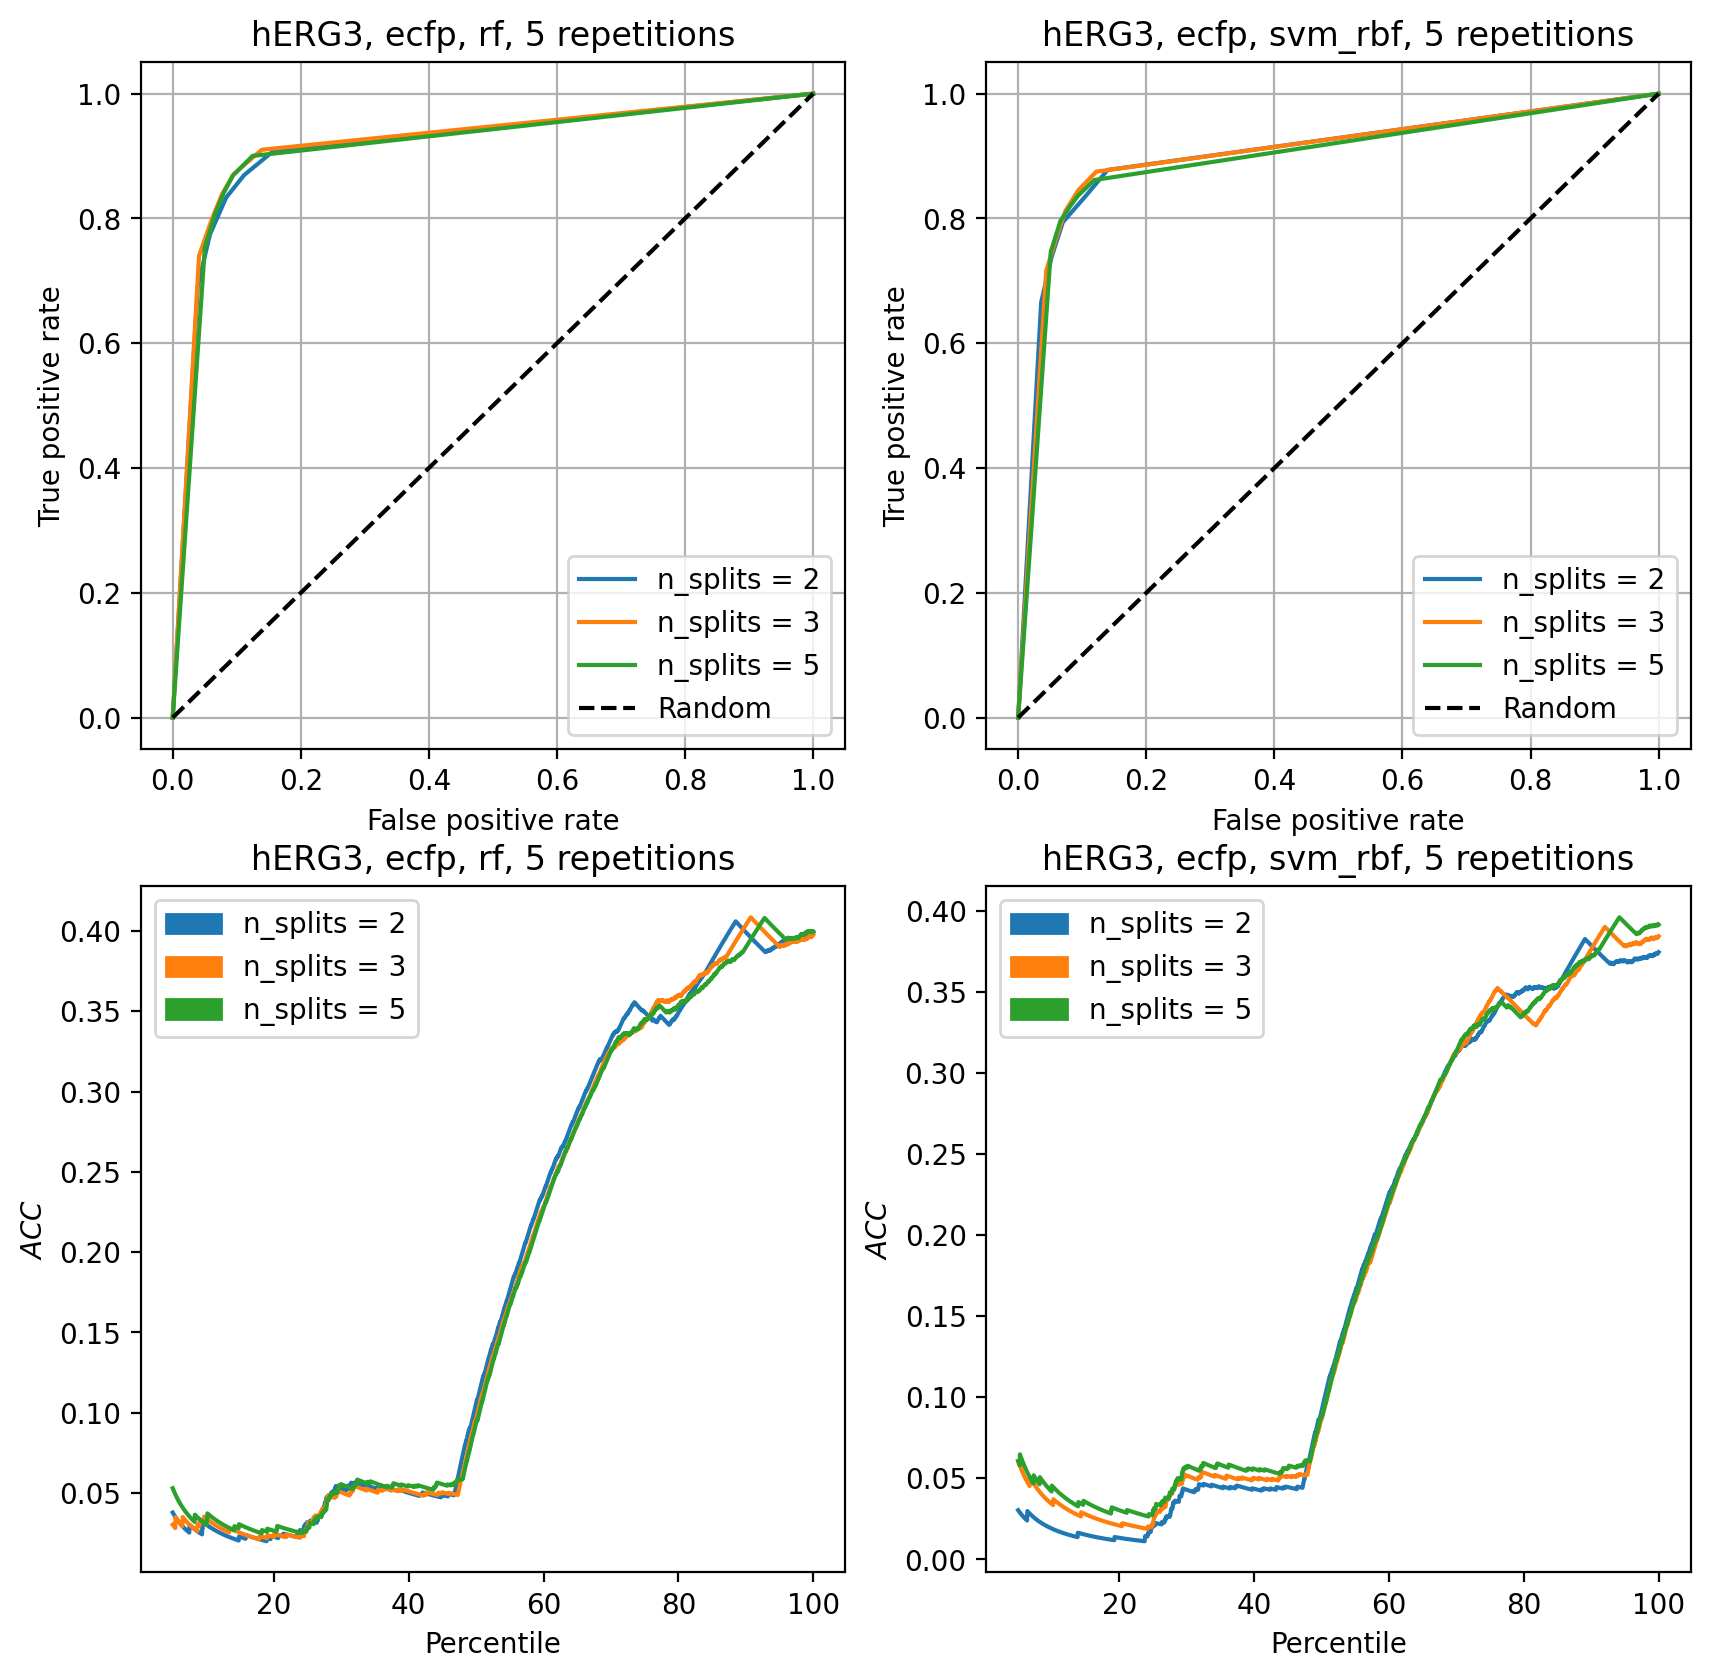

In [21]:
evaluation_automatization('hERG3', 'ecfp', ['rf', 'svm_rbf'], repetitions=5)

Repetition [1/3]


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.47s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 10/10 [00:30<00:00,  3.02s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 10/10 [00:55<00:00,  5.52s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 10/10 [02:06<00:00, 12.66s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 10/10 [04:56<00:00, 29.66s/it]


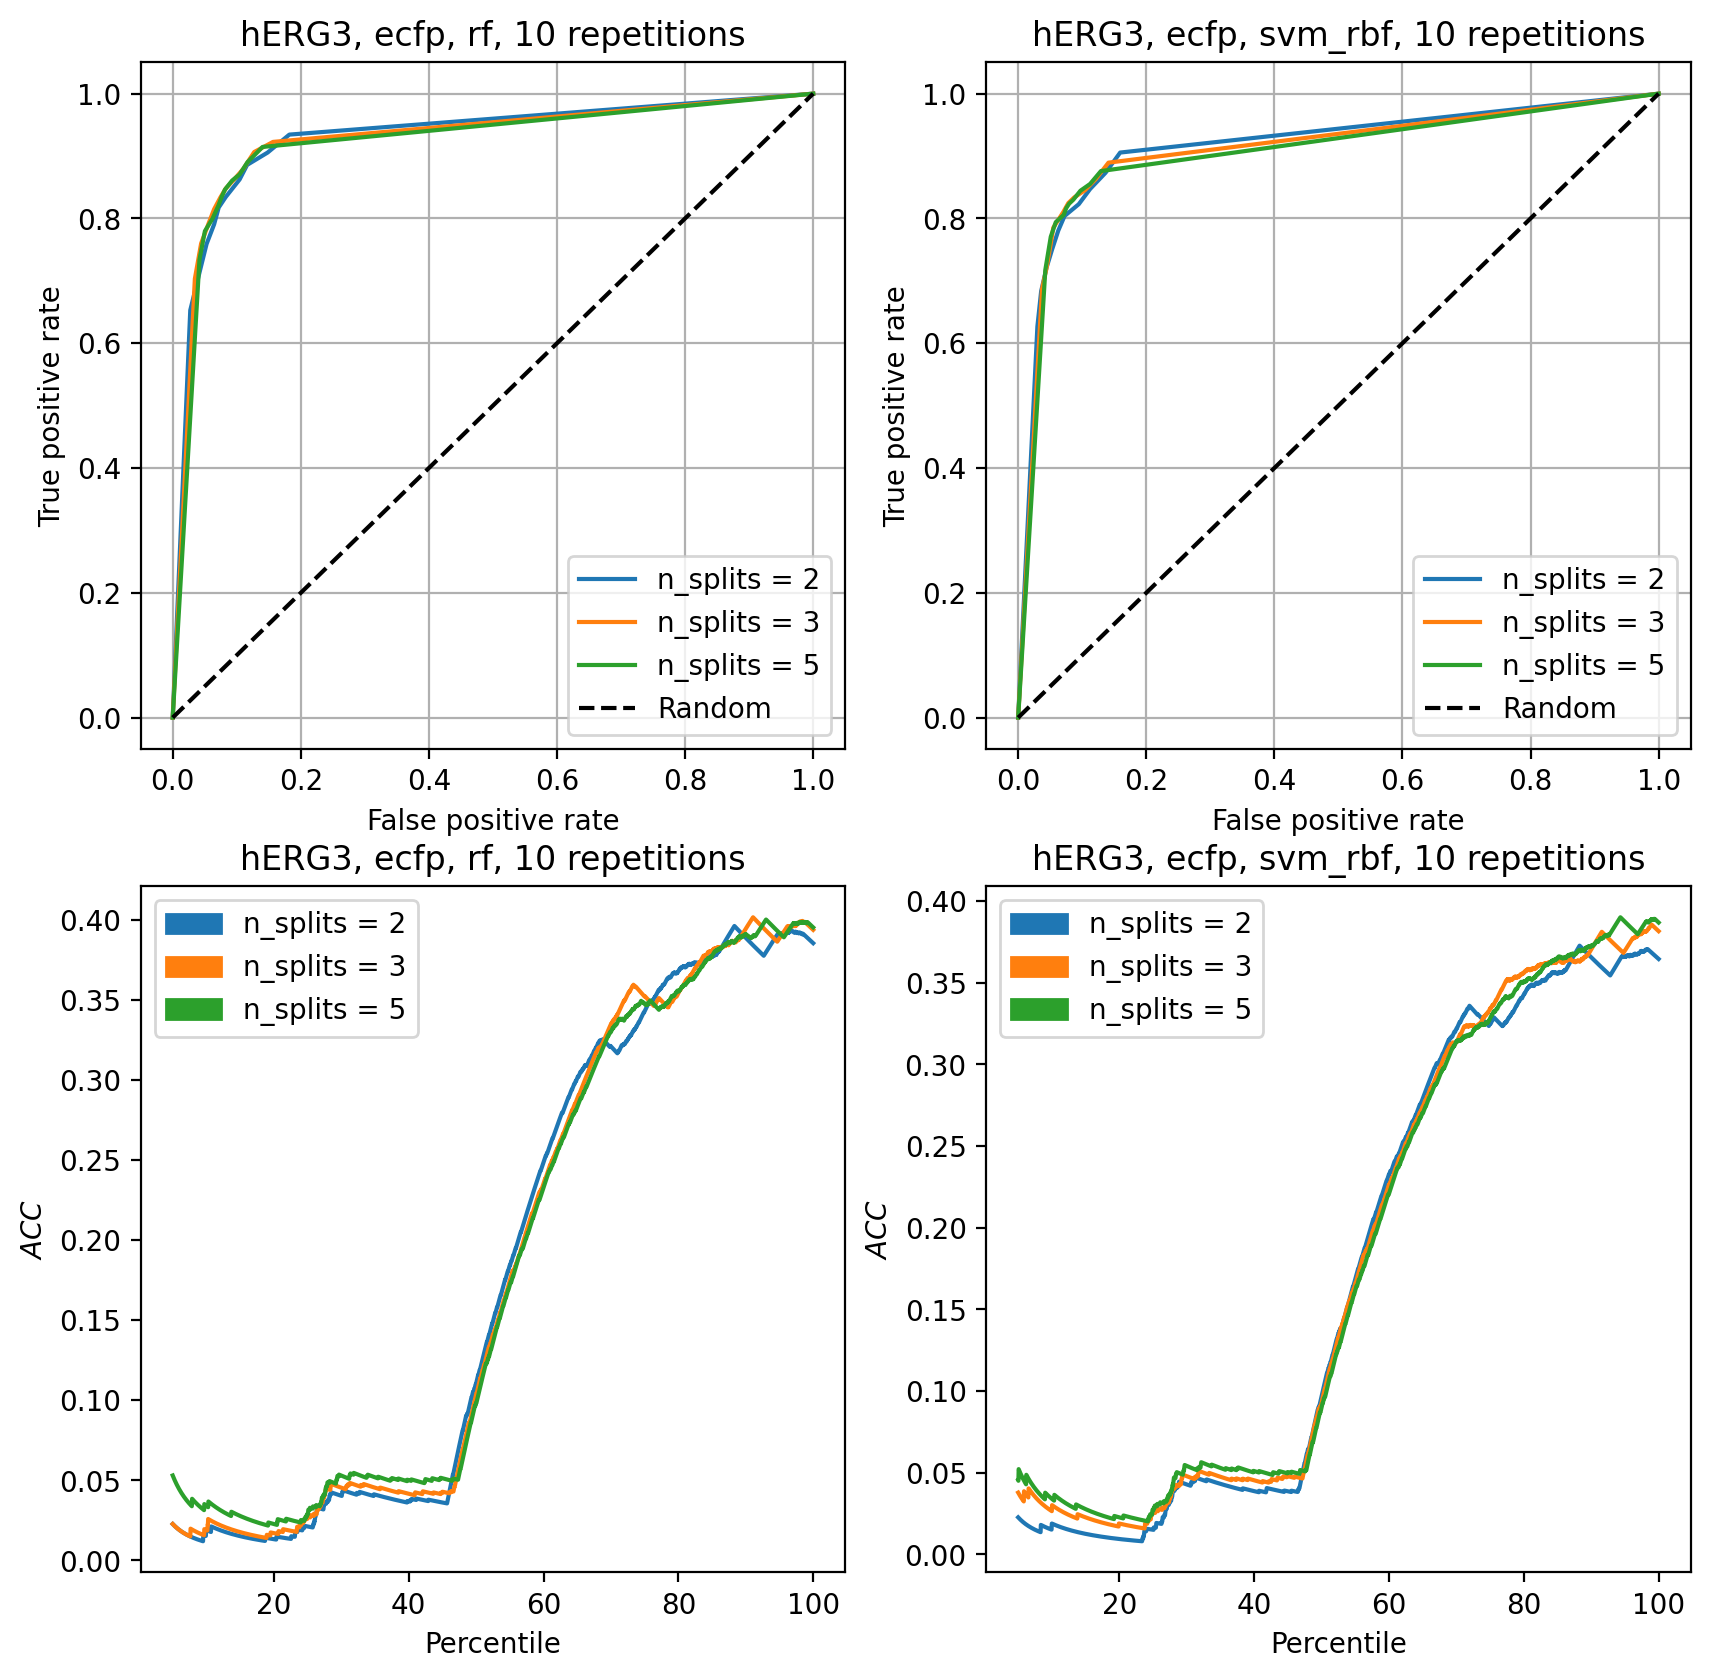

In [22]:
evaluation_automatization('hERG3', 'ecfp', ['rf', 'svm_rbf'], repetitions=10)

Repetition [1/3]


100%|███████████████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 15/15 [00:21<00:00,  1.41s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 15/15 [00:40<00:00,  2.71s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 15/15 [01:20<00:00,  5.34s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 15/15 [02:47<00:00, 11.14s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 15/15 [06:37<00:00, 26.49s/it]


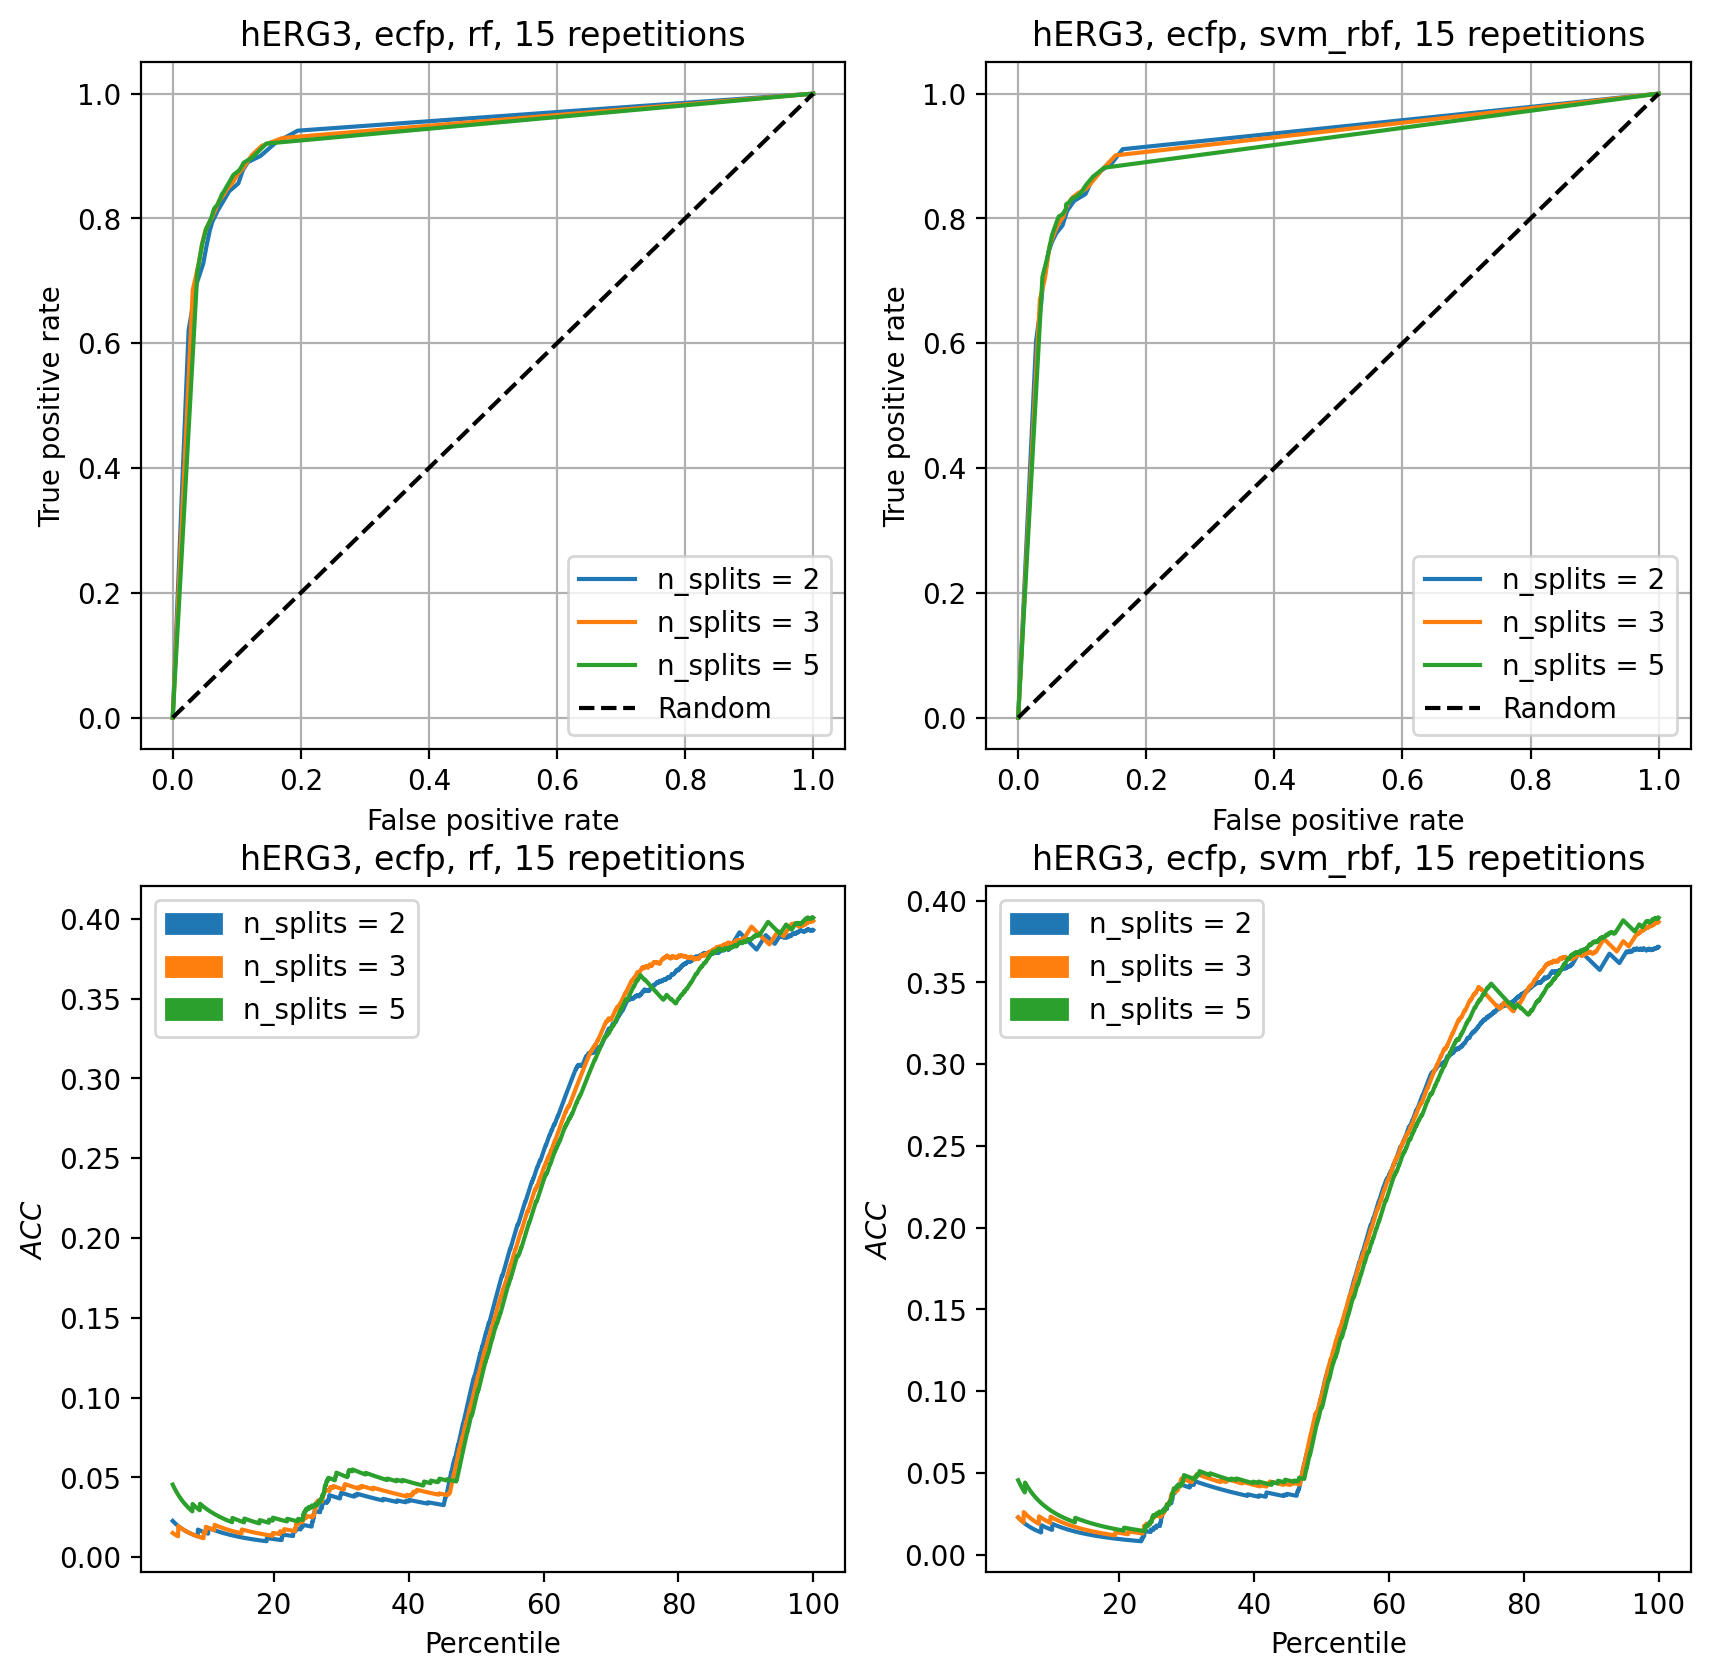

In [23]:
evaluation_automatization('hERG3', 'ecfp', ['rf', 'svm_rbf'], repetitions=15)

Repetition [1/3]


100%|███████████████████████████████████████████| 25/25 [00:18<00:00,  1.37it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 25/25 [00:34<00:00,  1.39s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 25/25 [01:09<00:00,  2.77s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 25/25 [02:13<00:00,  5.33s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 25/25 [04:30<00:00, 10.83s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 25/25 [10:37<00:00, 25.49s/it]


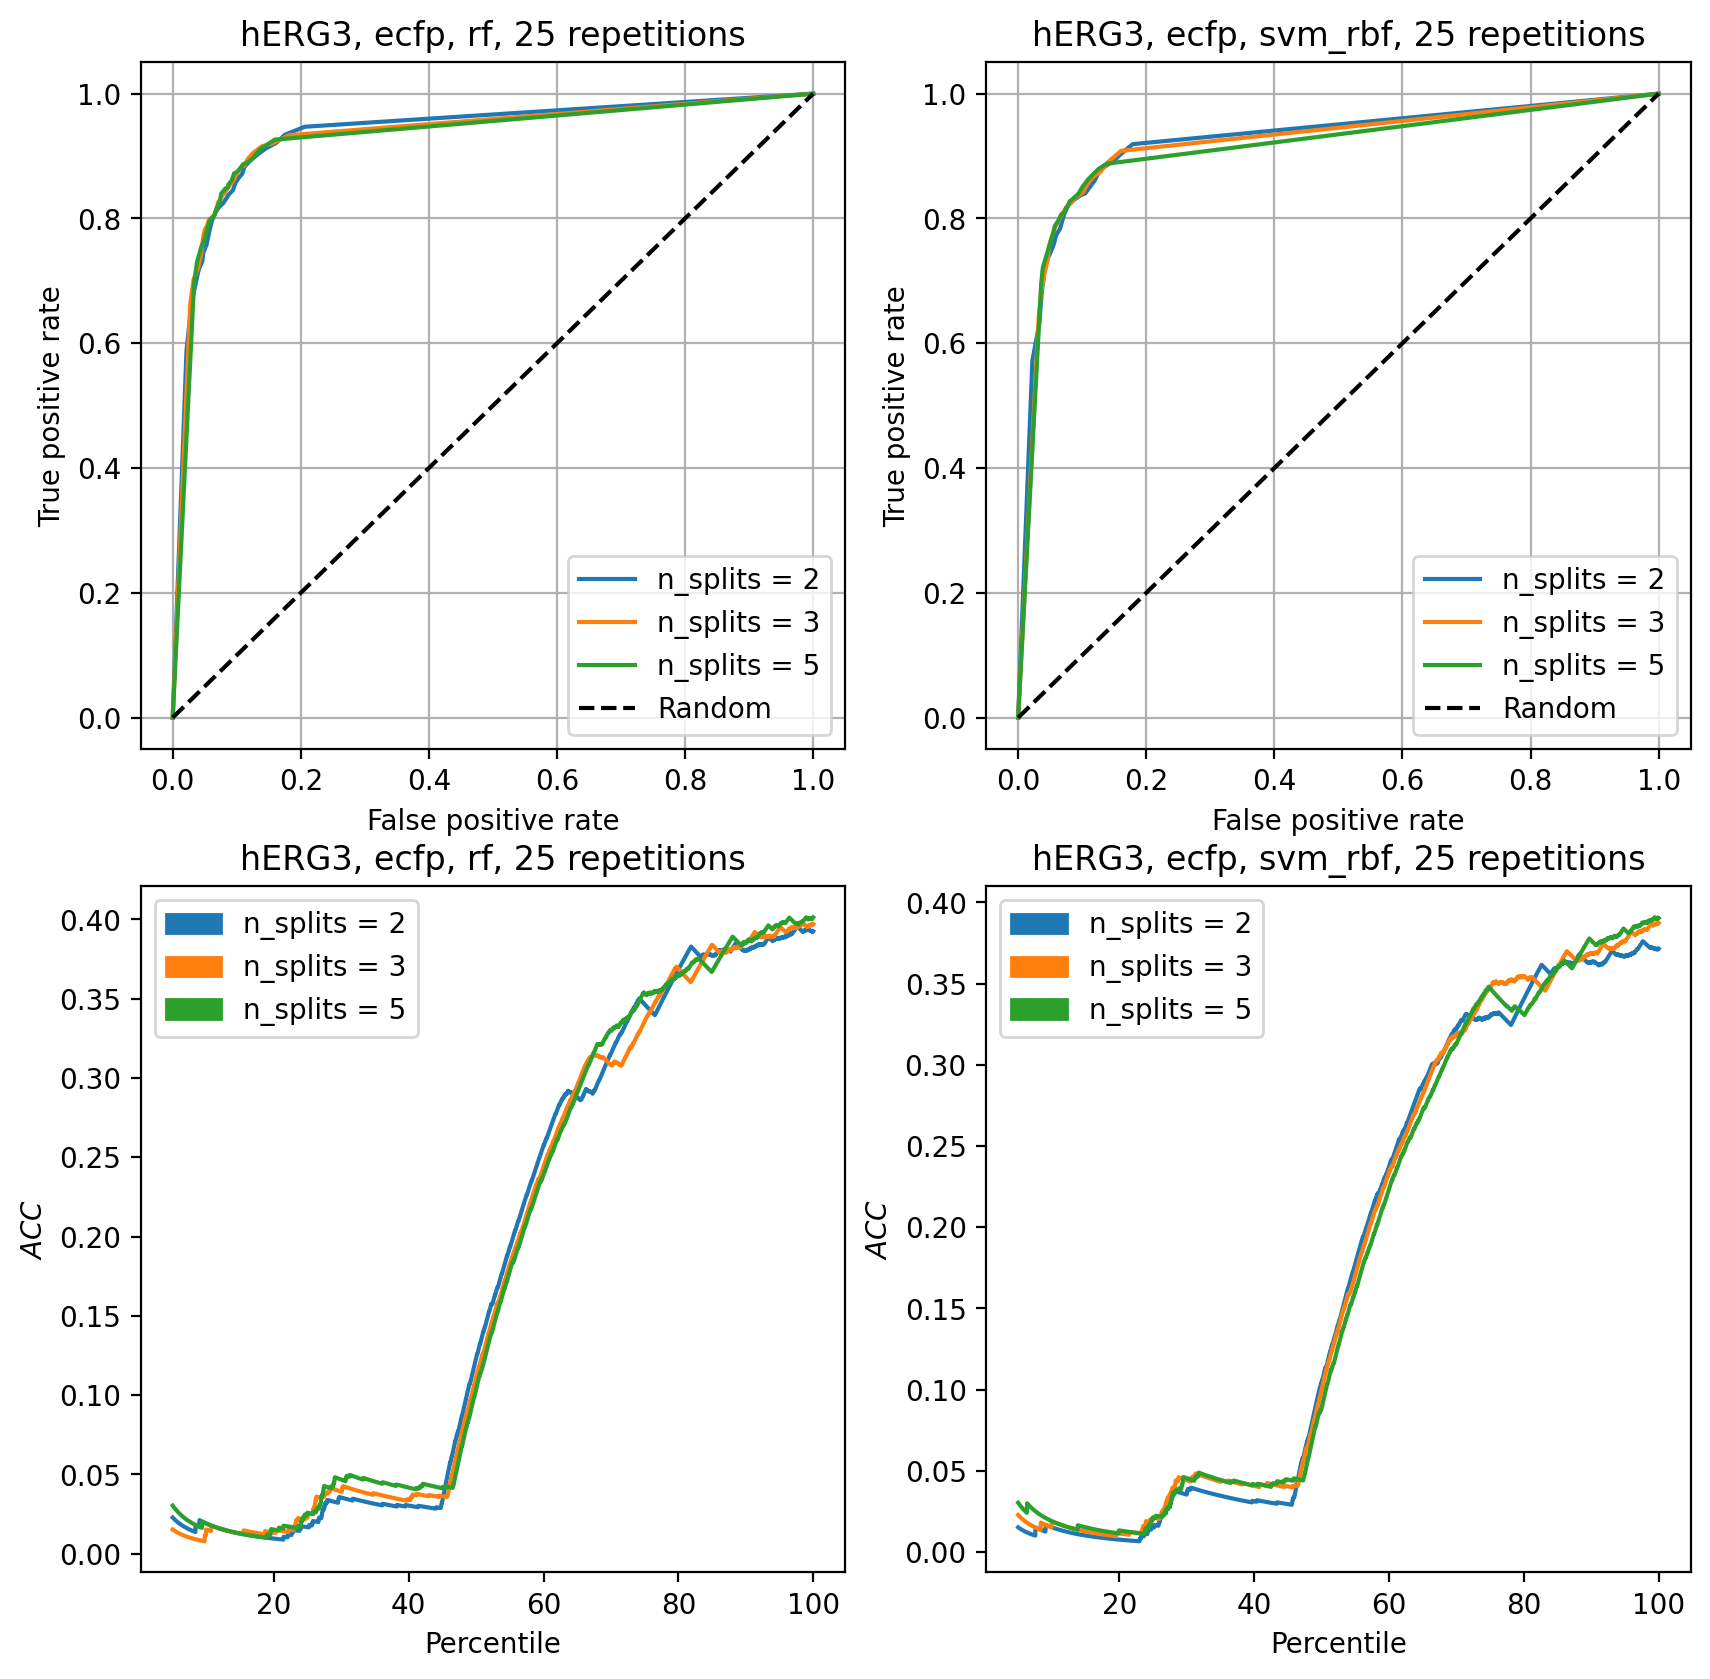

In [24]:
evaluation_automatization('hERG3', 'ecfp', ['rf', 'svm_rbf'], repetitions=25)

Repetition [1/3]


100%|███████████████████████████████████████████| 50/50 [00:37<00:00,  1.33it/s]


Repetition [2/3]


100%|███████████████████████████████████████████| 50/50 [01:09<00:00,  1.40s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 50/50 [02:23<00:00,  2.86s/it]


Repetition [1/3]


100%|███████████████████████████████████████████| 50/50 [04:38<00:00,  5.58s/it]


Repetition [2/3]


100%|███████████████████████████████████████████| 50/50 [10:06<00:00, 12.14s/it]


Repetition [3/3]


100%|███████████████████████████████████████████| 50/50 [24:04<00:00, 28.90s/it]


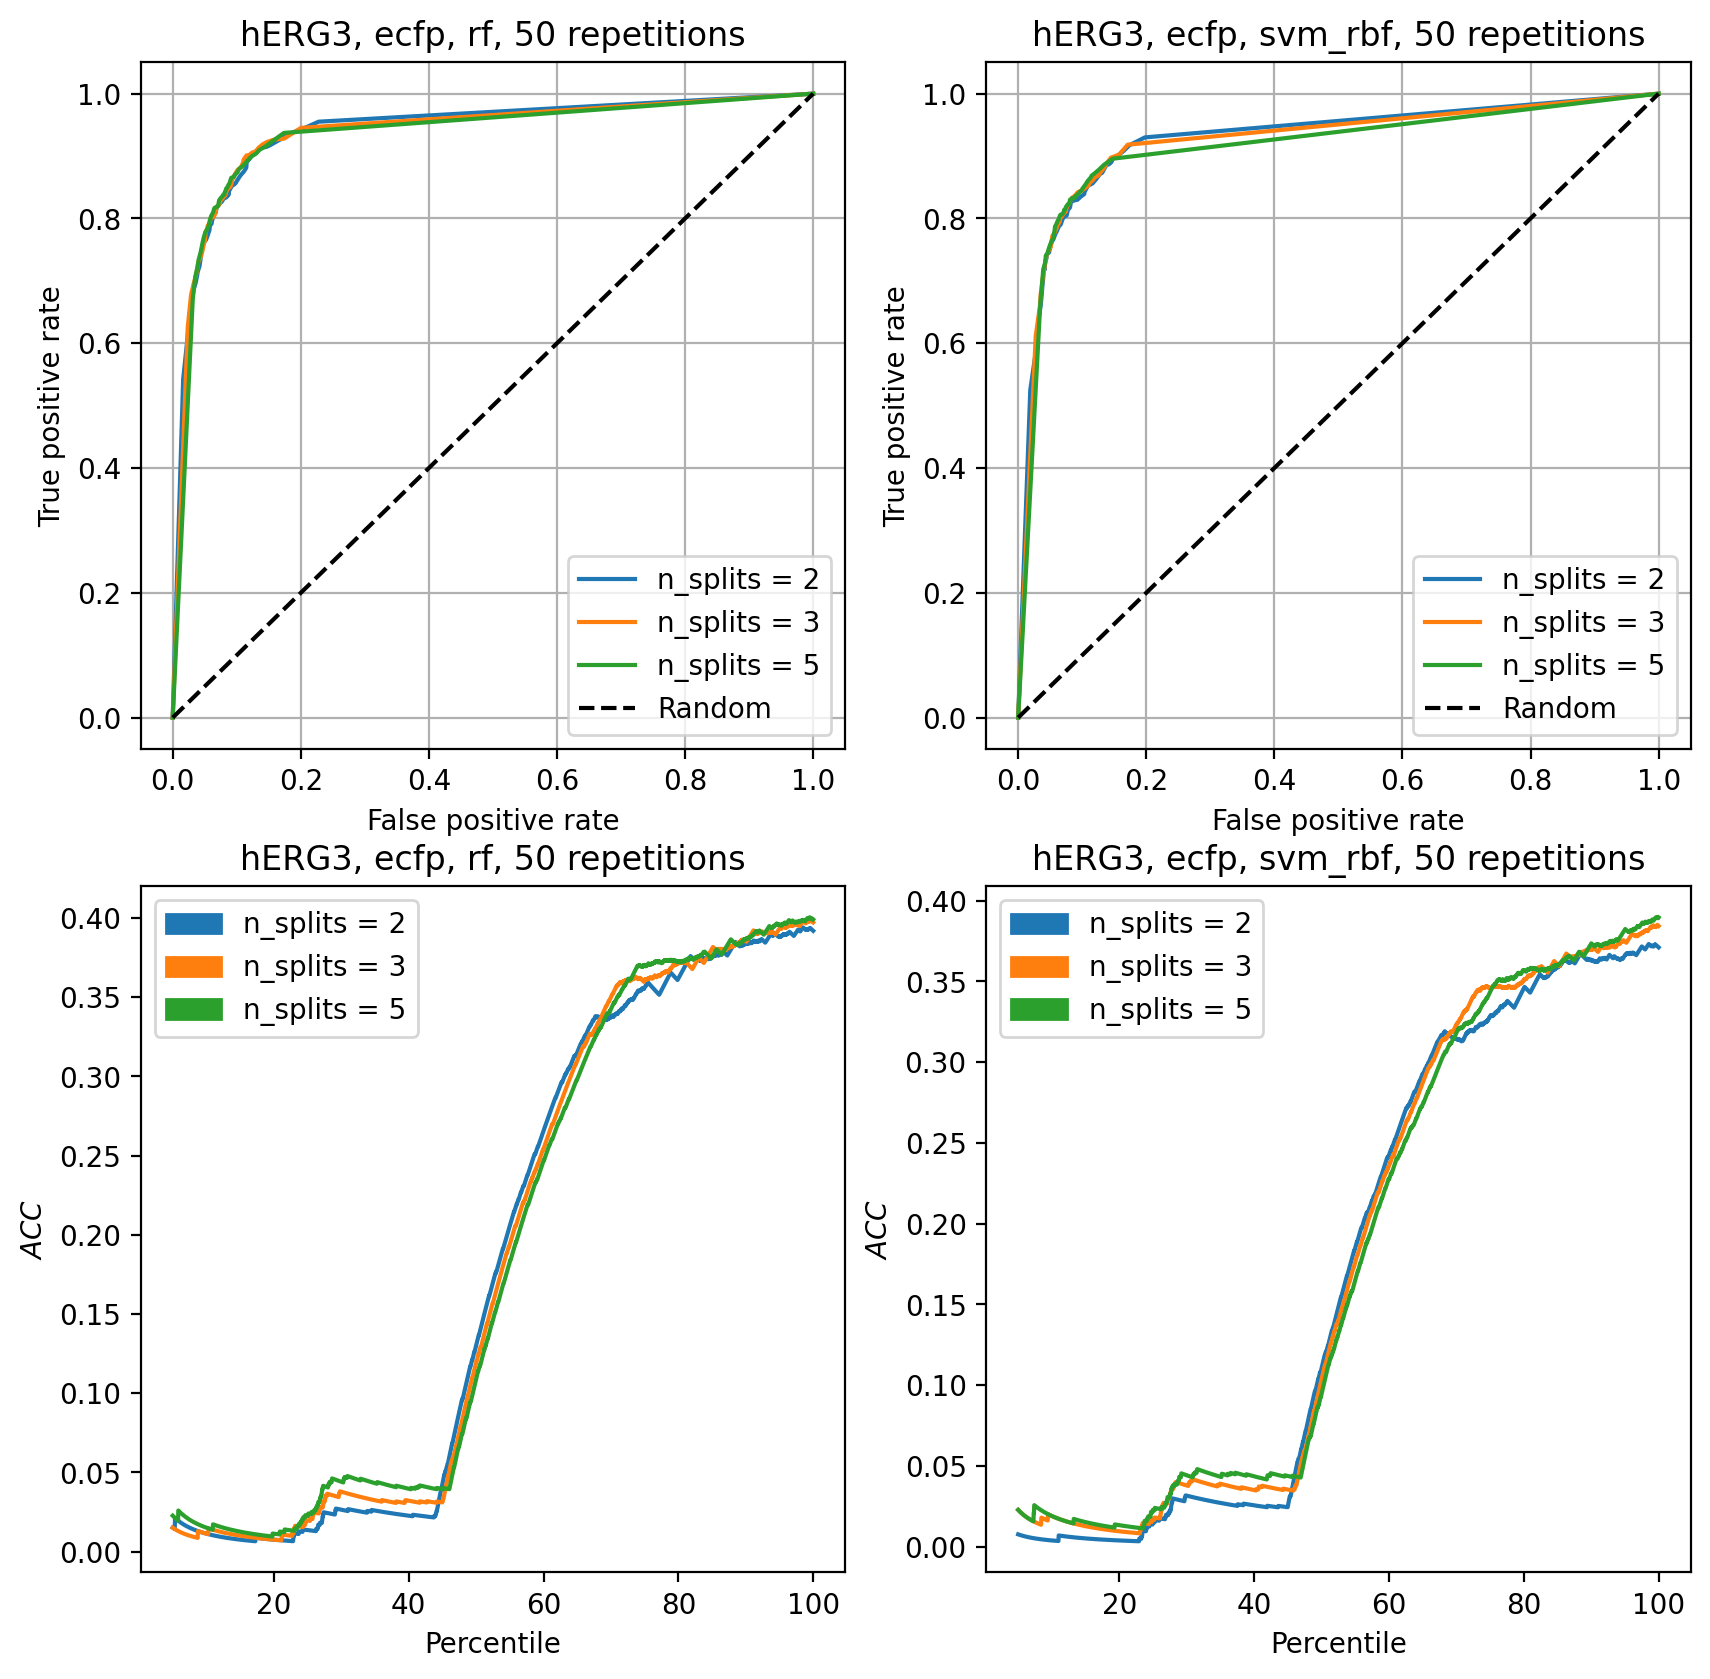

In [25]:
evaluation_automatization('hERG3', 'ecfp', ['rf', 'svm_rbf'], repetitions=50)

Repetition [1/3]


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Repetition [2/3]


100%|█████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


Repetition [3/3]


100%|█████████████████████████████████████████| 100/100 [04:25<00:00,  2.66s/it]


Repetition [1/3]


100%|█████████████████████████████████████████| 100/100 [08:30<00:00,  5.10s/it]


Repetition [2/3]


100%|█████████████████████████████████████████| 100/100 [17:24<00:00, 10.44s/it]


Repetition [3/3]


100%|█████████████████████████████████████████| 100/100 [39:50<00:00, 23.90s/it]


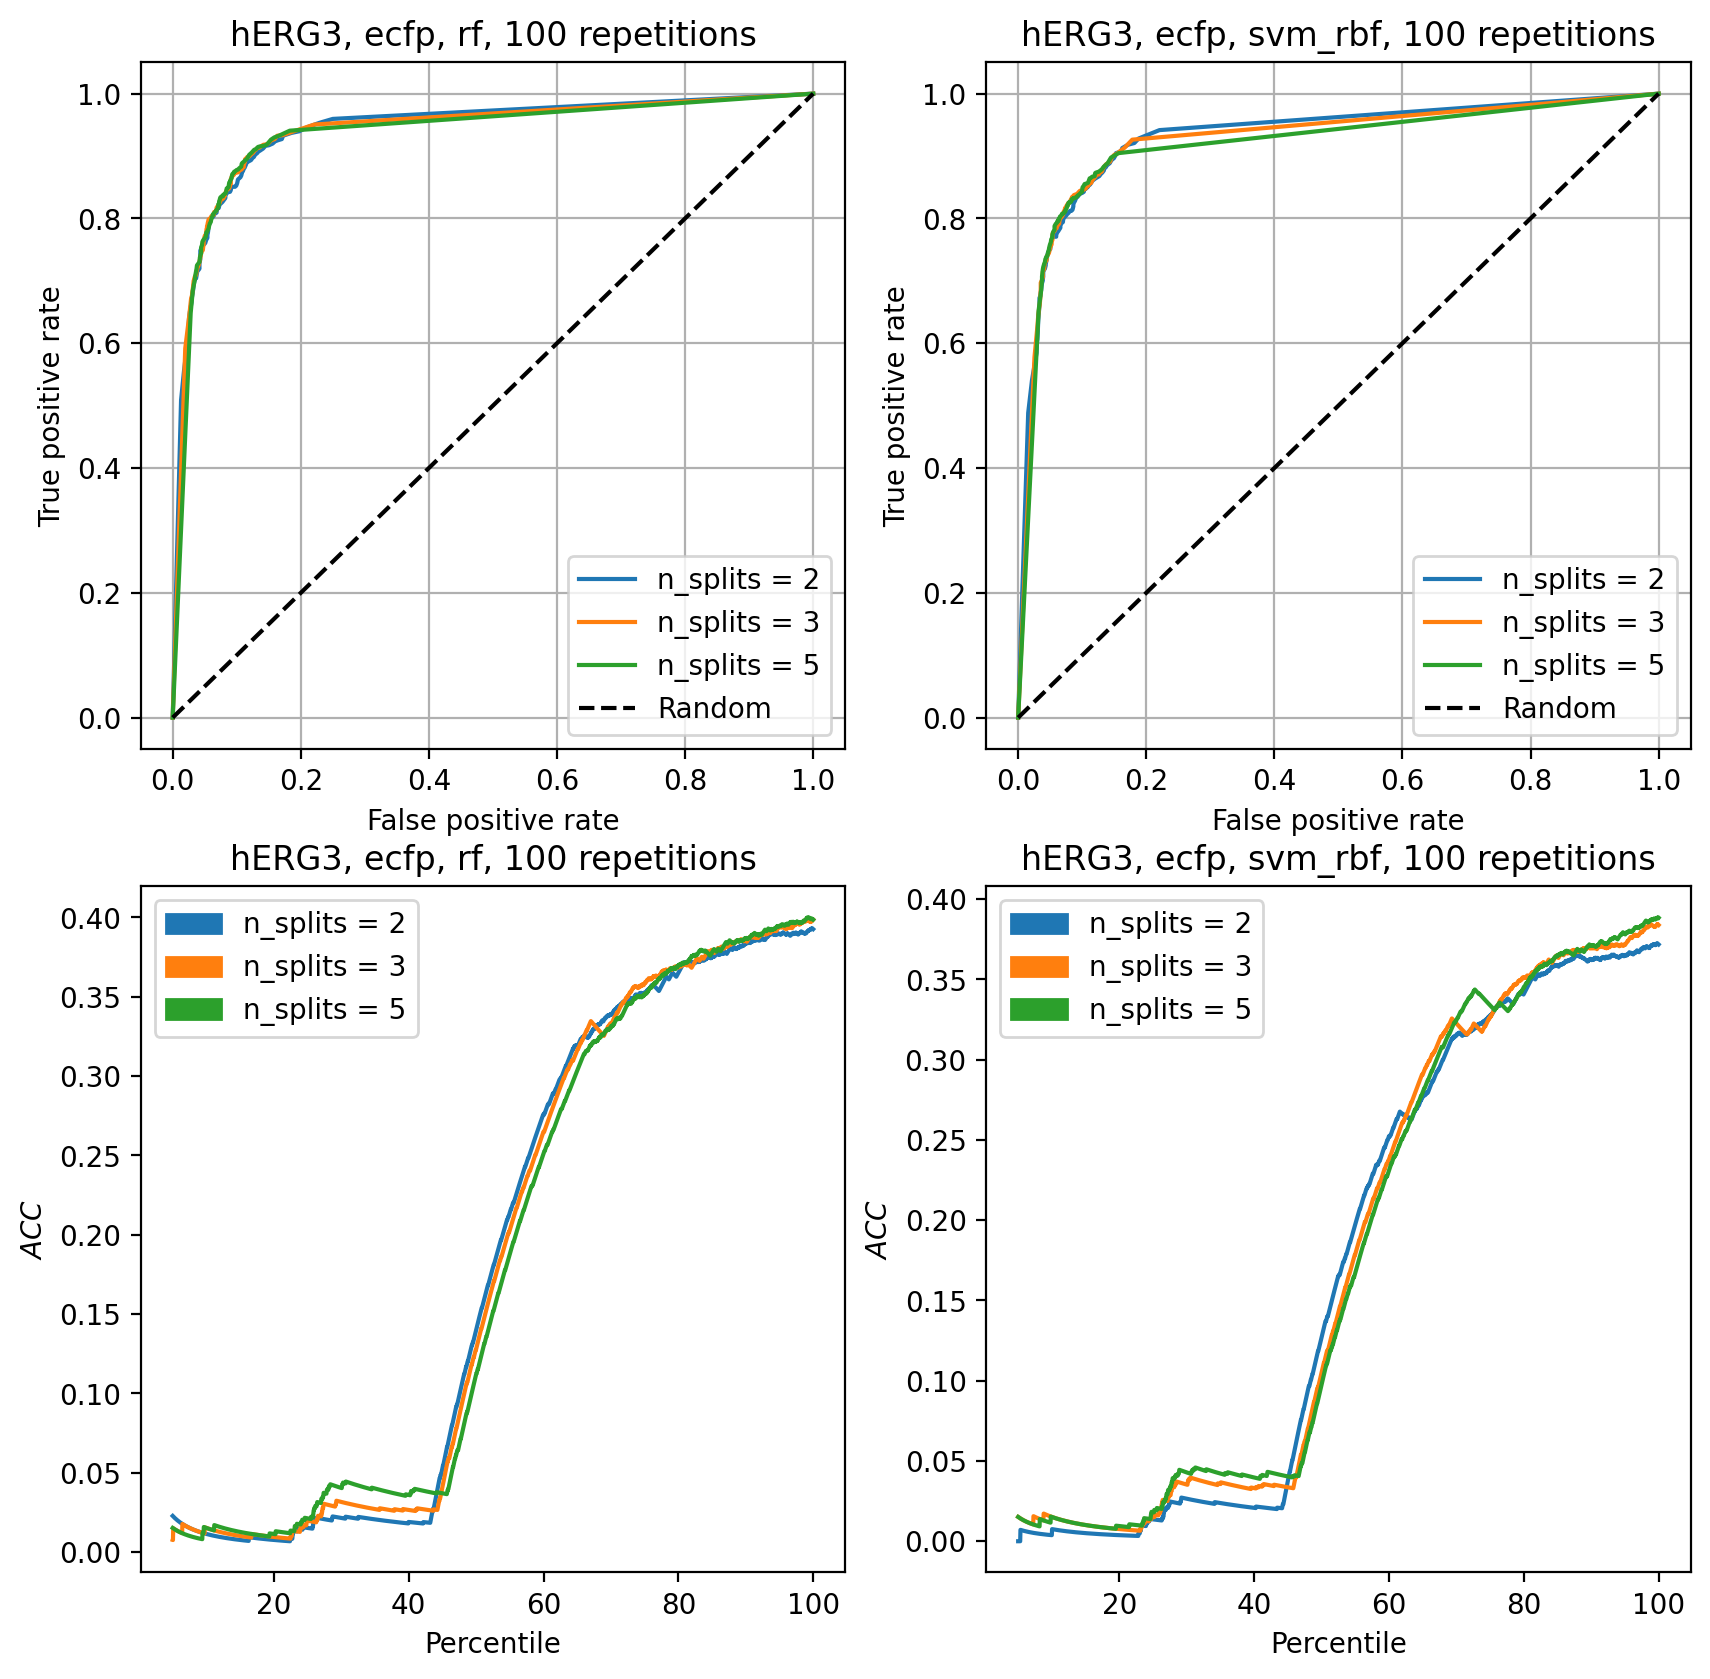

In [26]:
evaluation_automatization('hERG3', 'ecfp', ['rf', 'svm_rbf'], repetitions=100)

#### Testing multiple: